# Initial setup

This analysis using ema is based on the work of Enayat A. Moallemi created on 22 May 2018 at the Fraunhofer ISI, Karlsruhe. In that instance, the analysis was done for the MATISSE model.

In [2]:

"""
Based on Enayat A. Moallemi version from May 2018

edited by Angela M. Rojas A. <angelara@student.unimelb.edu.au>

Created on February 2020
"""

import sys
import os

sys.path.append(r'C:\Users\angel\Documents\GitHub\gr4sp\experiments\EMAworkbench')

sys.path.append(r'C:\Users\angel\Documents\GitHub\gr4sp\experiments')

#from ema_workbench.analysis.plotting_util import BOXPLOT, KDE, VIOLIN
from ema_workbench.analysis.plotting import envelopes
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import seaborn as sns
from ema_workbench.analysis import prim
#import pareto
import os
import glob
import numpy as np
import pandas as pd
import os
import glob



## Load the results

In [3]:
from ema_workbench import load_results

#results = load_results(r'C:\Users\angel\Documents\GitHub\gr4sp\experiments\data\gr4sp_2020-Feb-20-years.tar.gz')
#results = load_results(r'C:\Users\angel\Documents\GitHub\gr4sp\experiments\data\gr4sp_2020-Feb-07_EET_allV3.tar.gz')
#results = load_results(r'C:\Users\angel\Documents\GitHub\gr4sp\experiments\data\gr4sp_2020-Feb-25-LHS.tar.gz')
results = load_results(r'C:/Users/angel/Documents/GitHub/gr4sp/experiments/simulationData/gr4sp_2020-Jul-11-SOBOL.tar.gz')

experiments, outcomes = results

In [4]:
experiments.describe()

annualCpi  annualInflation  capacityFactorChangeBrownCoal  \
count  49152.000000     49152.000000                   49152.000000   
mean       0.030000         0.030009                      -0.012695   
std        0.011547         0.011547                       6.058842   
min        0.010020         0.010020                     -10.000000   
25%        0.020010         0.020010                      -5.000000   
50%        0.030000         0.030000                       0.000000   
75%        0.039990         0.039990                       5.000000   
max        0.049980         0.049980                      10.000000   

       capacityFactorChangeWater   consumption  energyEfficiency  \
count               49152.000000  49152.000000      49152.000000   
mean                   -0.003418      2.002930          0.998535   
std                     6.057041      1.415605          0.816404   
min                   -10.000000      0.000000          0.000000   
25%                    -5.000000      1.000000          0.000000   
50%                     0.000000      2.000000          1.000000   
75%                     5.000000      3.000000          2.000000   
max                    10.000000      4.000000          2.000000   

       generationRolloutPeriod  generatorRetirement  \
count             49152.000000         49152.000000   
mean                  4.997559             0.000000   
std                   3.160687             3.161229   
min                   0.000000            -5.000000   
25%                   2.000000            -3.000000   
50%                   5.000000             0.000000   
75%                   8.000000             3.000000   
max                  10.000000             5.000000   

       includePublicallyAnnouncedGen  learningCurve  ...  \
count                   49152.000000   49152.000000  ...   
mean                        0.500000       0.050013  ...   
std                         0.500005       0.028866  ...   
min                         0.000000       0.000049  ...   
25%                         0.000000       0.025024  ...   
50%                         0.500000       0.050000  ...   
75%                         1.000000       0.074976  ...   
max                         1.000000       0.099951  ...   

       priceChangePercentageOcgt  priceChangePercentageWater  \
count               49152.000000                49152.000000   
mean                   -0.011719                    0.010254   
std                    17.607574                   17.609114   
min                   -30.000000                  -30.000000   
25%                   -15.000000                  -15.000000   
50%                     0.000000                    0.000000   
75%                    15.000000                   15.000000   
max                    30.000000                   30.000000   

       priceChangePercentageWind     rooftopPV  scheduleMinCapMarketGen  \
count               49152.000000  49152.000000             49152.000000   
mean                   -0.008301      6.000488                19.999512   
std                    17.609005      0.816405                 6.057687   
min                   -30.000000      5.000000                10.000000   
25%                   -15.000000      5.000000                15.000000   
50%                     0.000000      6.000000                20.000000   
75%                    15.000000      7.000000                25.000000   
max                    30.000000      7.000000                30.000000   

       semiScheduleGenSpotMarket  semiScheduleMinCapMarketGen   solarUptake  \
count               49152.000000                 49152.000000  49152.000000   
mean                    8.999023                    15.063801      2.000000   
std                     0.814908                     8.631086      1.414918   
min                     8.000000                     0.114600      0.000000   
25%                     8.000000                     7.582300      1.000

In [5]:
outcomes_to_show = ['consumptionYear', 'tariffsYear', 'wholesalePriceYear', 'GHGYear', 
                    'primarySpotProductionYear', 'secondarySpotProductionYear', 
                    'offSpotProductionYear', 'renewableContributionYear', 'rooftopPVProductionYear', 
                    'coalProductionYear', 'waterProductionYear', 'windProductionYear', 'gasProductionYear', 
                    'solarProductionYear', 'BatteryProductionYear']

# 23 levers/uncertainties selected after EET (last test July 2020)
uncertainties = experiments.columns[:-3]

#from startYear
startYear = 2000
startYearShift = (startYear - 1998)

time = outcomes['TIMEYear'][0, startYearShift:]

points_of_interest = [*range(2000,2051,10)] 
points_of_interest = [ x - startYear for x in points_of_interest]

# Filter outcomes taking into account the startYear, and removing Seed Experiment info. 
# Seed it is useful if I want to retrieve more info from the csv files, or redo the experiments with the
# simulation parameters
outcomes_filtered = {k:v[:, startYearShift:] for k,v in outcomes.items() if k != 'seedExperimentCsv'}


## Aggregate Household data

GHG emissions and Consumption per household type converted to total sector


In [6]:
ooi = 'GHGYear'
data_GHG_household = outcomes_filtered[ooi]

In [7]:
""" Converts household data in tCO2e into total residential data in MtCO2e"""
data_GHG_residential = (data_GHG_household * outcomes_filtered['numConsumersYear']) / 1000000.0

""" Applies scaling factor used in simulation, so that data represents total emissions, not only residential"""
data_GHG_total = data_GHG_residential / (1/3)

"""Overwrite GHG with the data of interest"""
outcomes_filtered[ooi] = data_GHG_total

In [8]:
ooi = 'consumptionYear'
data_consumption_household = outcomes_filtered[ooi]

In [9]:
""" Converts household data in KWh into total residential data in MWh"""
data_consumption_residential = (data_consumption_household * outcomes_filtered['numConsumersYear']) / 1000.0

""" Applies scaling factor used in simulation, so that data represents total consumption, not only residential"""
data_consumption_total = data_consumption_residential / (1/3)

"""Overwrite Consumption with the data of interest"""
outcomes_filtered[ooi] = data_consumption_total

# Target functions

In [10]:
def target_always_after(outcomes,ooi,targetYear,targetVal,above):
    data = outcomes[ooi]
    num_exp = len(data)
    achieved = np.zeros(num_exp, dtype=bool)

    for i in range(num_exp):
        achieved[i] = False
        exp_run = data[i]
        for j in range( len(exp_run) ):
            if (startYear + j) >= targetYear:
                if above is True:
                    achieved[i] = exp_run[j] >= targetVal
                else:
                    achieved[i] = exp_run[j] < targetVal
                    
                #If the target is not achieved after the TargetYear, then mark experiment as False
                if achieved[i] == False:
                    break
    return achieved

def target_at_year(outcomes,ooi,targetYear,targetVal,above):
    data = outcomes[ooi]
    num_exp = len(data)
    achieved = np.zeros(num_exp, dtype=bool)

    for i in range(num_exp):
        achieved[i] = False
        exp_run = data[i]
        
        idx = targetYear - startYear
        if above is True:
            achieved[i] = exp_run[idx] >= targetVal
        else:
            achieved[i] = exp_run[idx] < targetVal                        
                
    return achieved

# Scenario discovery

## GHG emissions


Truncate experiments and outcomes for a selected policy and a selected outcome over mean in time series

In [11]:
#Subset of levers/uncertainties
#selected_levers = list(['rooftopPV', 'annualCpi','capacityFactorChangeBrownCoal','capacityFactorChangeWater','semiScheduleMinCapMarketGen'])    
selected_uncertainties = uncertainties

ooi = 'GHGYear'

data = outcomes_filtered[ooi]


num_exp = len(data)
out_avg_ooi = np.zeros(num_exp)

for i in range(num_exp):
    out_avg_ooi[i] = data[i].mean()

exp = pd.DataFrame(experiments)

exp = exp.loc[ :, selected_uncertainties] 

The following section uses PRIM, feature scoring and dimensional stacking to find the cases that represent futures in three main groups: Low Carbon, Just Transition and Resilient Transition.

It uses targets (e.g. cases for which emissions are the lowest at year x) to filter out the cases and find out the corresponding input variables and ranges for the cases to happen.

The first case is on GHG emissions. To find out the targets for exploration, first let's analyse the envelope diagram (see below) showing how the transition may unfold:

### Open Exploration: Visual Analysis

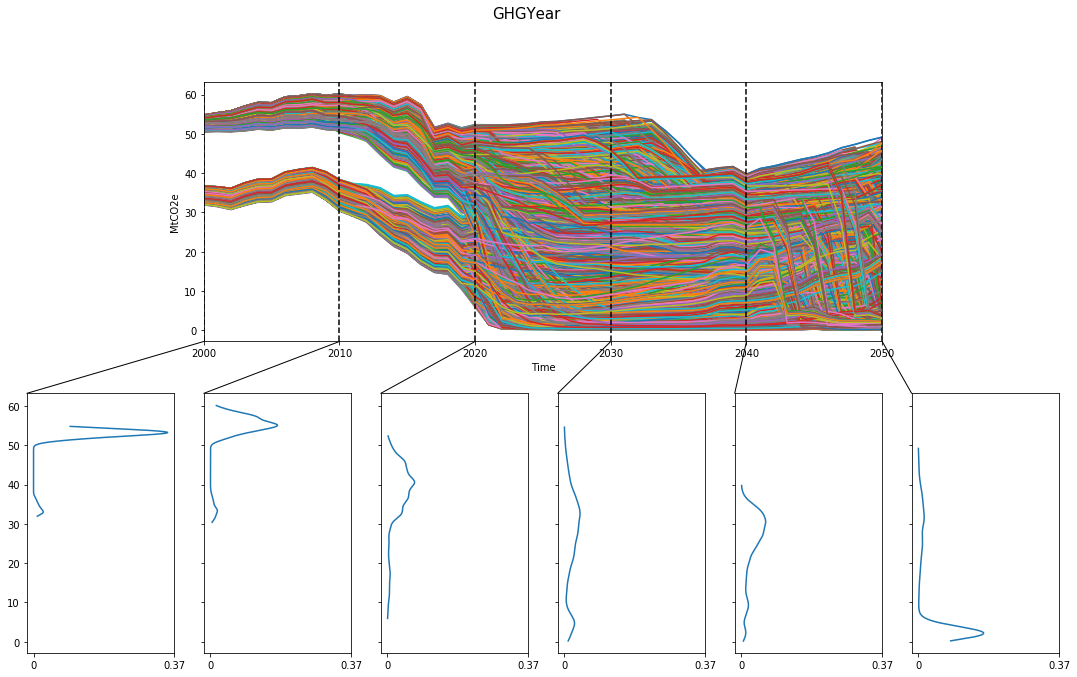

In [236]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density 

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest, density = Density.KDE, grouping_specifiers=None, 
                                 titles={ooi}, ylabels={ooi: "MtCO2e"}, legend=True,
                                 fill=False, plot_type=PlotType.ENV_LIN)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])

## Show labels
# labels = ax_env['F']['main plot'].get_xticklabels()
# for l in labels:
#     print (l.get_text)

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_line_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')
    

KeyboardInterrupt: 

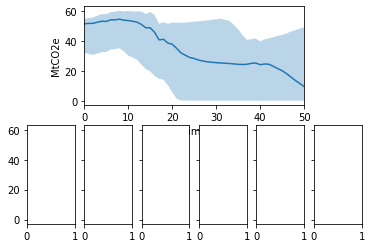

In [12]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density 

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest, density = Density.KDE, grouping_specifiers=None,
                                 titles={ooi}, ylabels={ooi: "MtCO2e"}, legend=True,
                                 fill=True, plot_type=PlotType.ENVELOPE)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])

## Show labels
# labels = ax_env['F']['main plot'].get_xticklabels()
# for l in labels:
#     print (l.get_text)

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')


As the envelope shows, there are two main groups at the first years of analysis where GHG emissions either increase or decrease. However, as time passes, GHG emissions can vary widely. 
Taking the first year of analysis, year 2020, we can investigate the cases where GHG emissions per year per household fall below 30.89 MtonsCO2-e. This is 20% lower than the emissions in BAU for 2005, which were 38.62 MtCO2-e

### Scenario Discovery: Prim

In [238]:
from EMAworkbench.ema_workbench.analysis import prim
from EMAworkbench.ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);
 
x = exp
#y = (out_avg_ooi < 4.)
y = target_at_year( outcomes_filtered, ooi, 2020, 30.89 , False) #False is below target

#Threshold for density
prim_alg = prim.Prim(x, y, threshold=0.5)
box1 = prim_alg.find_box()



[MainProcess/INFO] 49152 points remaining, containing 5613 cases of interest
[MainProcess/INFO] mean: 0.8467711119602599, mass: 0.053243001302083336, coverage: 0.3947977908426866, density: 0.8467711119602599 restricted_dimensions: 4


In [239]:
box1.inspect_tradeoff()

alt.VConcatChart(...)

coverage    0.394798
density     0.846771
id                41
mass        0.053243
mean        0.846771
res_dim            4
Name: 41, dtype: object

                               box 41                                     
                                  min   max                      qp values
priceChangePercentageWater      -30.0 -15.5                    [-1.0, 0.0]
capacityFactorChangeBrownCoal   -10.0   5.5  [-1.0, 2.740426989746717e-29]
priceChangePercentageBrownCoal   10.5  30.0                    [0.0, -1.0]
capacityFactorChangeWater        -8.5  10.0  [4.475236437027728e-07, -1.0]



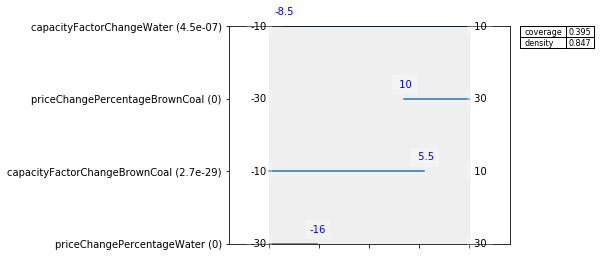

In [240]:
#%matplotlib inline
box_1 = box1.inspect(41)
box_1 = box1.inspect(41, style='graph')


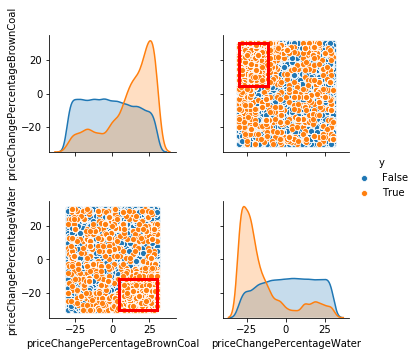

In [241]:
box1.select(30)
fig = box1.show_pairs_scatter(30)

plt.show()


### Feature Scoring

In [242]:
from EMAworkbench.ema_workbench.analysis import feature_scoring

fs, alg = feature_scoring.get_ex_feature_scores(x, y, mode=feature_scoring.RuleInductionType.CLASSIFICATION)
fs.sort_values(ascending=False, by=1)



1
0                                       
priceChangePercentageWater      0.234587
priceChangePercentageBrownCoal  0.174495
generationRolloutPeriod         0.089292
semiScheduleGenSpotMarket       0.058067
capacityFactorChangeBrownCoal   0.052740
capacityFactorChangeWater       0.052410
nonScheduleGenSpotMarket        0.046591
generatorRetirement             0.021540
nonScheduleMinCapMarketGen      0.020054
semiScheduleMinCapMarketGen     0.019797
scheduleMinCapMarketGen         0.019590
solarUptake                     0.019041
energyEfficiency                0.018562
wholesaleTariffContribution     0.018109
rooftopPV                       0.018055
annualCpi                       0.017982
consumption                     0.017963
learningCurve                   0.017874
priceChangePercentageWind       0.017822
priceChangePercentageOcgt       0.016979
annualInflation                 0.016762
technologicalImprovement        0.015965
includePublicallyAnnouncedGen   0.015722

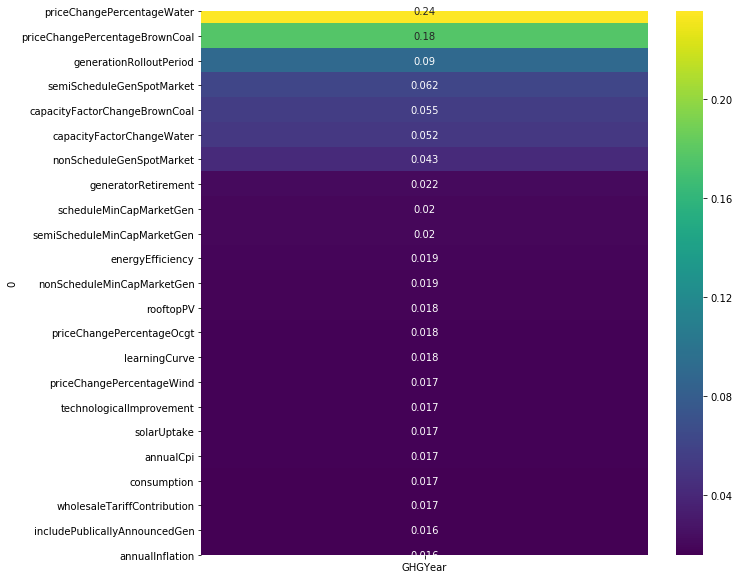

In [243]:
x = exp
y_all = {}

#plot using ALL simulations
#y_all['GHGYear'] = data

#plot using average of ALL simulations
#y_all['GHGYear'] = out_avg_ooi

#Plot using only target simulations
y_all['GHGYear'] = y

fig, ax = plt.subplots(figsize=(10,10))
fs = feature_scoring.get_feature_scores_all(x, y_all)
sns.heatmap(fs, cmap='viridis', annot=True, ax=ax)
plt.show()

### Dimensional Stacking


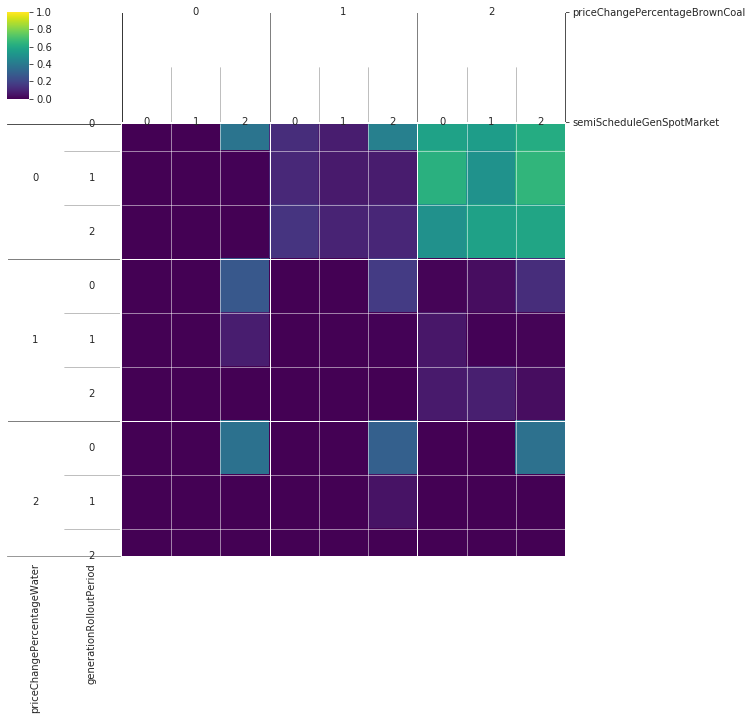

In [244]:

from EMAworkbench.ema_workbench.analysis import dimensional_stacking

x = exp
dimensional_stacking.create_pivot_plot(x,y, 2, nbins=3)
plt.show()



## Wholesale Price

In [31]:
# Subset Sobol levers
#selected_levers = list(['rooftopPV','annualCpi', 'generationRolloutPeriod', 'generatorRetirement','capacityFactorChangeBrownCoal','semiScheduleMinCapMarketGen'])    

select_uncertainties = uncertainties
ooi = 'wholesalePriceYear'
data = outcomes_filtered[ooi]

num_exp = len(data)
out_avg_ooi = np.zeros(num_exp)

for i in range(num_exp):
    out_avg_ooi[i] = data[i].mean()

exp = pd.DataFrame(experiments)

exp = exp.loc[ :, select_uncertainties] 

### Open Exploration: Visual Analysis

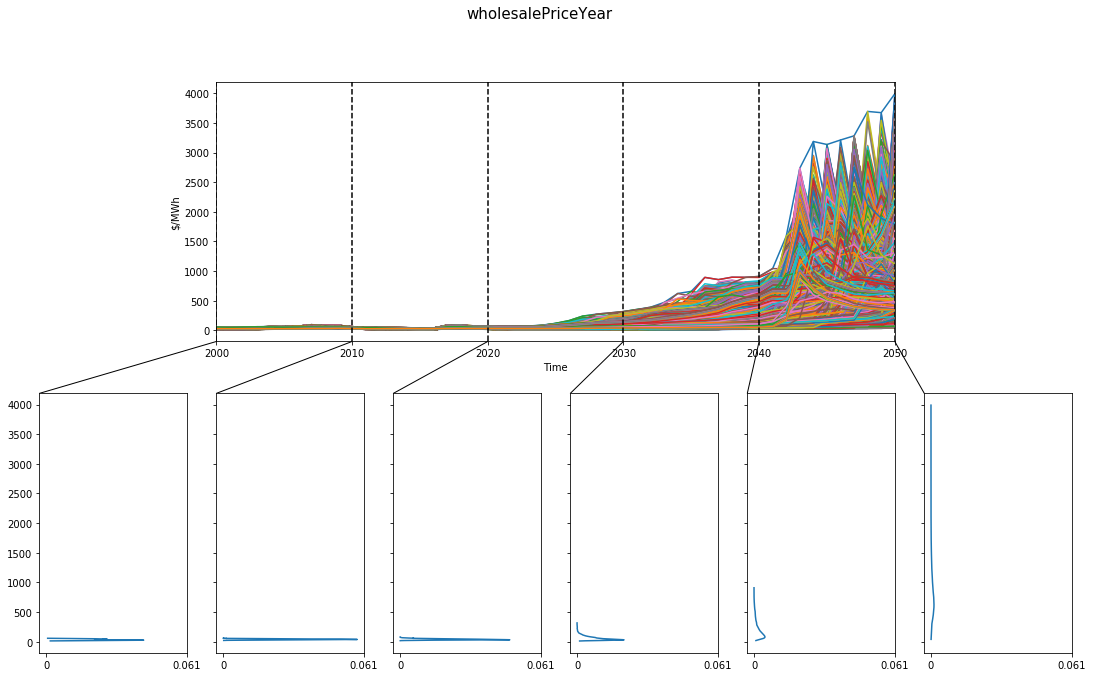

In [246]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density 

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "$/MWh"}, legend=True,
                                 fill=False, plot_type=PlotType.ENV_LIN)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_line_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

Densities: {'14.1 to 18.1': '0.008', '18.1 to 22.2': '0.024', '22.2 to 26.2': '0.039', '26.2 to 30.2': '0.034', '30.2 to 34.3': '0.022', '34.3 to 38.3': '0.025', '38.3 to 42.3': '0.025', '42.3 to 46.4': '0.026', '46.4 to 50.4': '0.024', '50.4 to 54.4': '0.016', '54.4 to 58.5': '0.004'}
Densities: {'22.2 to 25.9': '0.002', '25.9 to 29.6': '0.017', '29.6 to 33.4': '0.036', '33.4 to 37.1': '0.047', '37.1 to 40.9': '0.056', '40.9 to 44.6': '0.053', '44.6 to 48.4': '0.036', '48.4 to 52.1': '0.015', '52.1 to 55.9': '0.004'}
Densities: {'17.9 to 23.4': '0.002', '23.4 to 29.0': '0.014', '29.0 to 34.5': '0.043', '34.5 to 40.0': '0.043', '40.0 to 45.6': '0.035', '45.6 to 51.1': '0.023', '51.1 to 56.6': '0.013', '56.6 to 62.1': '0.005', '62.1 to 67.7': '0.002'}
Densities: {'12.7 to 40.4': '0.014', '40.4 to 68.1': '0.011', '68.1 to 95.9': '0.006', '95.9 to 123.6': '0.003', '123.6 to 151.3': '0.001'}
Densities: {'20.3 to 101.2': '0.004', '101.2 to 182.1': '0.004', '182.1 to 263.0': '0.002', '263.0 

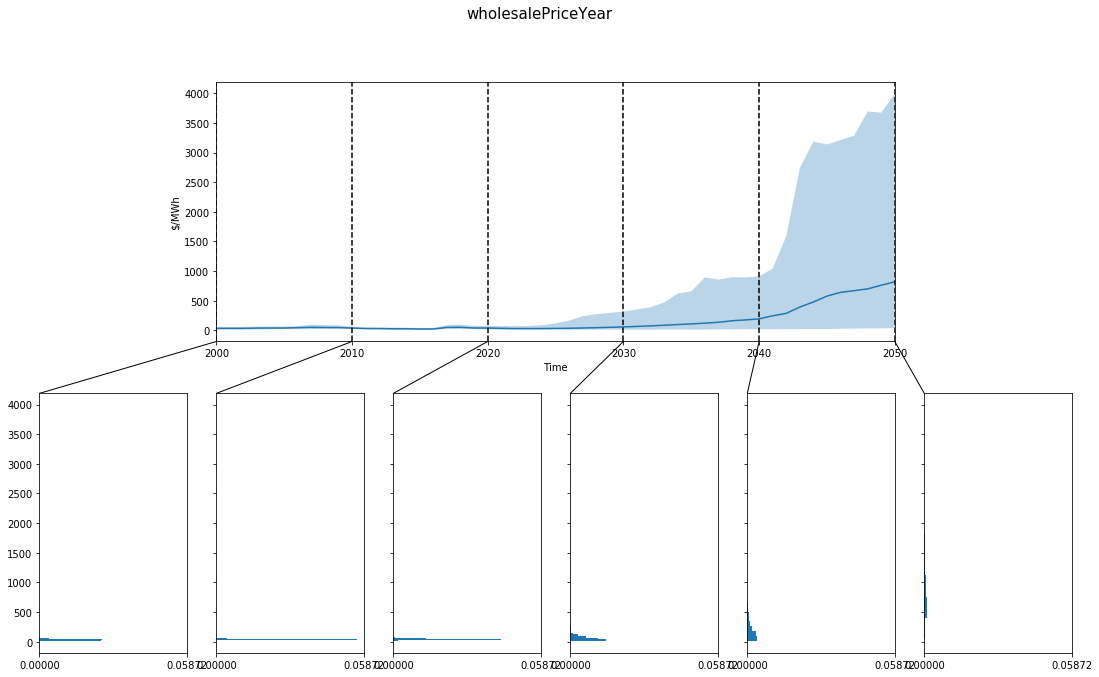

In [32]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.HIST,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "$/MWh"}, legend=True,
                                 fill=True, plot_type=PlotType.ENVELOPE)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')



Wholesale prices: 20-25% by 2025 on 2017 levels
Spot price in 2017 ~103 $/MWh (OpenNem) in simulation BAU VIC 48.05. In 2025 should be below 38.44-36.03 (20-25%)

In [248]:
from EMAworkbench.ema_workbench.analysis import prim
from EMAworkbench.ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);
 
x = exp
#y = out_avg_ooi > 80

y = target_at_year( outcomes_filtered, ooi, 2025, 36.03, False) #False is below target

prim_alg = prim.Prim(x, y, threshold=.8, threshold_type=prim.ABOVE)
box1 = prim_alg.find_box()

[MainProcess/INFO] 49152 points remaining, containing 32641 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.08990478515625, coverage: 0.1353818816825465, density: 1.0 restricted_dimensions: 13


In [249]:
box1.inspect_tradeoff()

alt.VConcatChart(...)

We can see that the targets are __not ambitious enough__, and is sufficient to __delay slightly the rollout of renewables__, and **avoid the earliest retirement of brown coal**

coverage    0.781318
density     0.936233
id                 3
mass        0.554199
mean        0.936233
res_dim            3
Name: 3, dtype: object

                          box 3                                       
                            min   max                        qp values
semiScheduleGenSpotMarket   8.5  10.0                      [0.0, -1.0]
generationRolloutPeriod     0.5  10.0  [1.4054772066625907e-196, -1.0]
generatorRetirement        -4.5   5.0    [4.022111329261576e-49, -1.0]



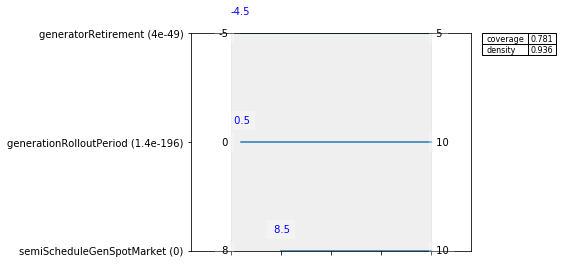

In [250]:
%matplotlib inline
box_1 = box1.inspect(3)
box_1 = box1.inspect(3, style='graph')

### A more ambitious target
Wholesale prices: 50% by 2025 on 2017 levels
Spot price in 2017 ~103 $/MWh (OpenNem) in simulation BAU VIC 48.05. In 2025 should be below 24.02 (50%)

In [251]:
from EMAworkbench.ema_workbench.analysis import prim
from EMAworkbench.ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);
 
x = exp
#y = out_avg_ooi > 80

y = target_at_year( outcomes_filtered, ooi, 2025, 24.02, False) #False is below target

prim_alg = prim.Prim(x, y, threshold=.45, threshold_type=prim.ABOVE)
box1 = prim_alg.find_box()

[MainProcess/INFO] 49152 points remaining, containing 12067 cases of interest
[MainProcess/INFO] mean: 0.9988793425476279, mass: 0.054463704427083336, coverage: 0.2215960885058424, density: 0.9988793425476279 restricted_dimensions: 11


In [252]:
box1.inspect_tradeoff()

alt.VConcatChart(...)

coverage    0.555316
density     0.855156
id                13
mass        0.159424
mean        0.855156
res_dim            4
Name: 13, dtype: object

                               box 13                                      
                                  min   max                       qp values
priceChangePercentageBrownCoal  -30.0   1.5                     [-1.0, 0.0]
includePublicallyAnnouncedGen     0.5   1.0                     [0.0, -1.0]
semiScheduleGenSpotMarket         8.5  10.0                     [0.0, -1.0]
generationRolloutPeriod           0.5  10.0  [3.4095890818713436e-52, -1.0]



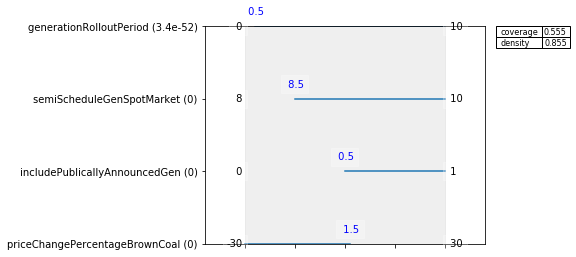

In [253]:
%matplotlib inline
box_1 = box1.inspect(13)
box_1 = box1.inspect(13, style='graph')


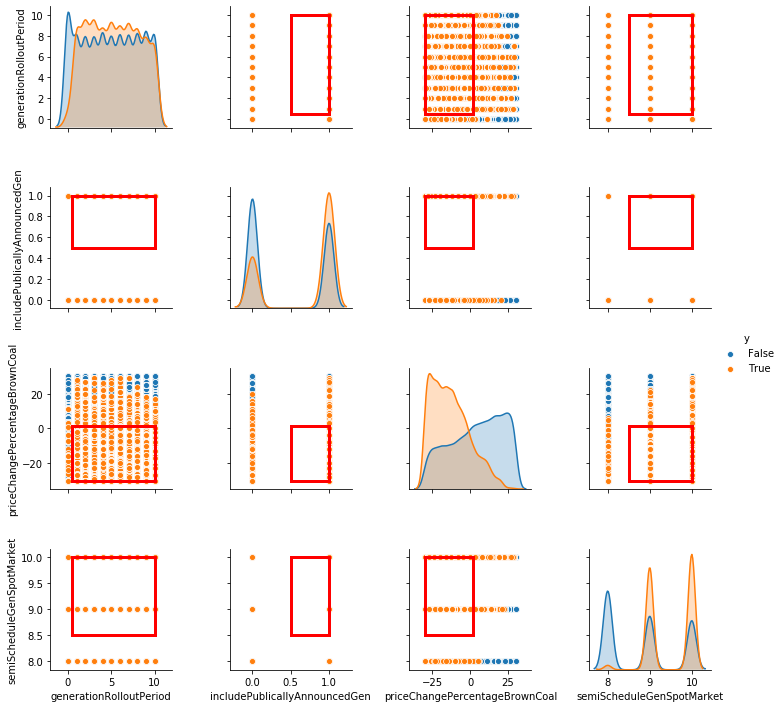

In [254]:
box1.select(13)
fig = box1.show_pairs_scatter(13)

plt.show()

### Feature Scoring

In [255]:
from EMAworkbench.ema_workbench.analysis import feature_scoring

fs, alg = feature_scoring.get_ex_feature_scores(x, y, mode=feature_scoring.RuleInductionType.CLASSIFICATION)
fs.sort_values(ascending=False, by=1)


1
0                                       
priceChangePercentageBrownCoal  0.259465
semiScheduleGenSpotMarket       0.222874
includePublicallyAnnouncedGen   0.080973
annualInflation                 0.072792
consumption                     0.048793
generationRolloutPeriod         0.047579
capacityFactorChangeBrownCoal   0.028822
priceChangePercentageWater      0.022955
generatorRetirement             0.021925
nonScheduleGenSpotMarket        0.015879
energyEfficiency                0.015256
nonScheduleMinCapMarketGen      0.014625
technologicalImprovement        0.014275
learningCurve                   0.014238
solarUptake                     0.013969
capacityFactorChangeWater       0.013664
annualCpi                       0.013646
priceChangePercentageOcgt       0.013571
scheduleMinCapMarketGen         0.013208
semiScheduleMinCapMarketGen     0.013134
priceChangePercentageWind       0.013053
rooftopPV                       0.012823
wholesaleTariffContribution     0.012480

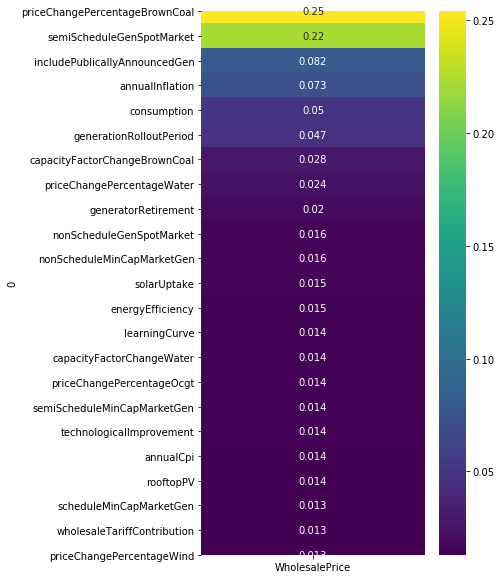

In [256]:
x = exp
y_all = {}

#plot using ALL simulations
#y_all['GHGYear'] = data

#plot using average of ALL simulations
#y_all['GHGYear'] = out_avg_ooi

#Plot using only target simulations
y_all['WholesalePrice'] = y

fig, ax = plt.subplots(figsize=(5,10))
fs = feature_scoring.get_feature_scores_all(x, y_all)
sns.heatmap(fs, cmap='viridis', annot=True, ax=ax)
plt.show()

### Dimensional stacking

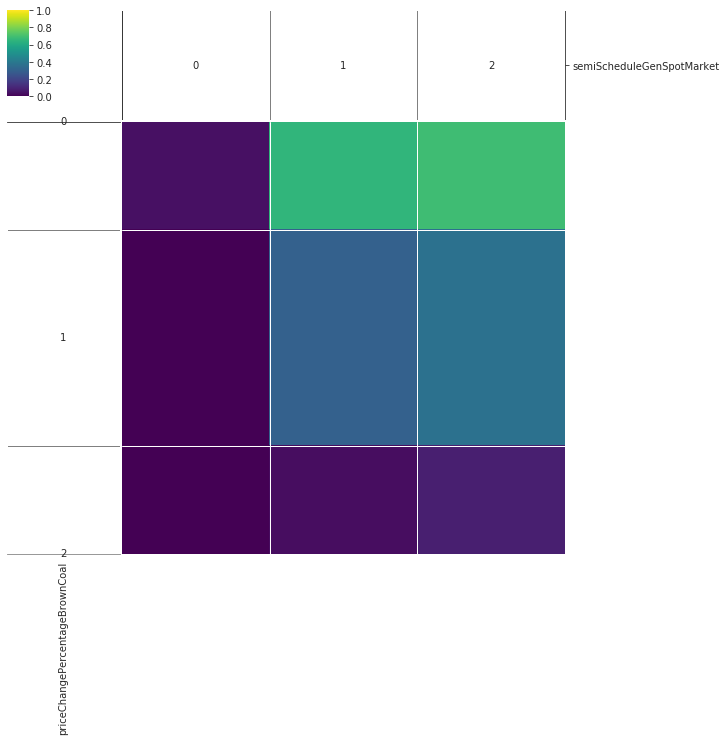

In [257]:

from EMAworkbench.ema_workbench.analysis import dimensional_stacking

x = exp
dimensional_stacking.create_pivot_plot(x,y, 1, nbins=3)
plt.show()



## Tariffs

In [313]:
# Subset Sool levers/uncertainties
selected_uncertainties = list(['consumption','rooftopPV','annualInflation','priceChangePercentageBrownCoal',
                        'priceChangePercentageWind','priceChangePercentageWater',
                        'capacityFactorChangeWater','retailUsageChange'])    

#selected_levers = levers
ooi = 'tariffsYear'
data = outcomes_filtered[ooi]

num_exp = len(data)
out_avg_ooi = np.zeros(num_exp)

for i in range(num_exp):
    out_avg_ooi[i] = data[i].mean()

exp = pd.DataFrame(experiments)

exp = exp.loc[ :, selected_uncertainties] 

C:\Users\angel\Anaconda3\lib\site-packages\pandas\core\indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


: 20-25% by 2025 on 2017. tariffs in 2017: ~21 c/KWh

### Open Exploration: Visual Analysis

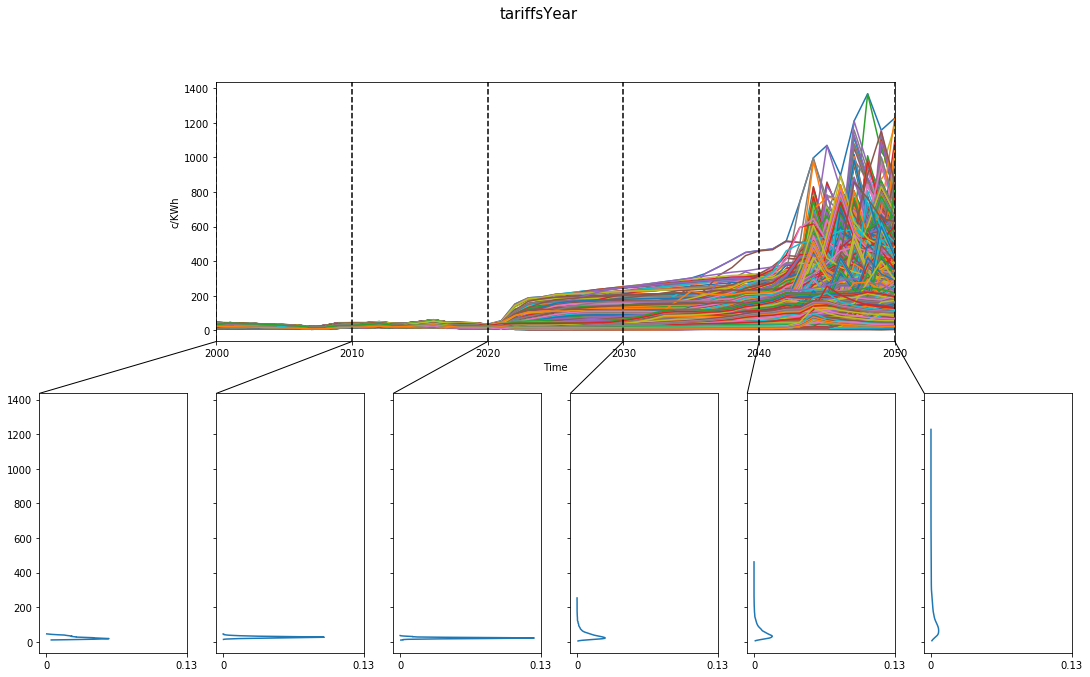

In [259]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "c/KWh"}, legend=True,
                                 fill=False, plot_type=PlotType.ENV_LIN)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_line_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

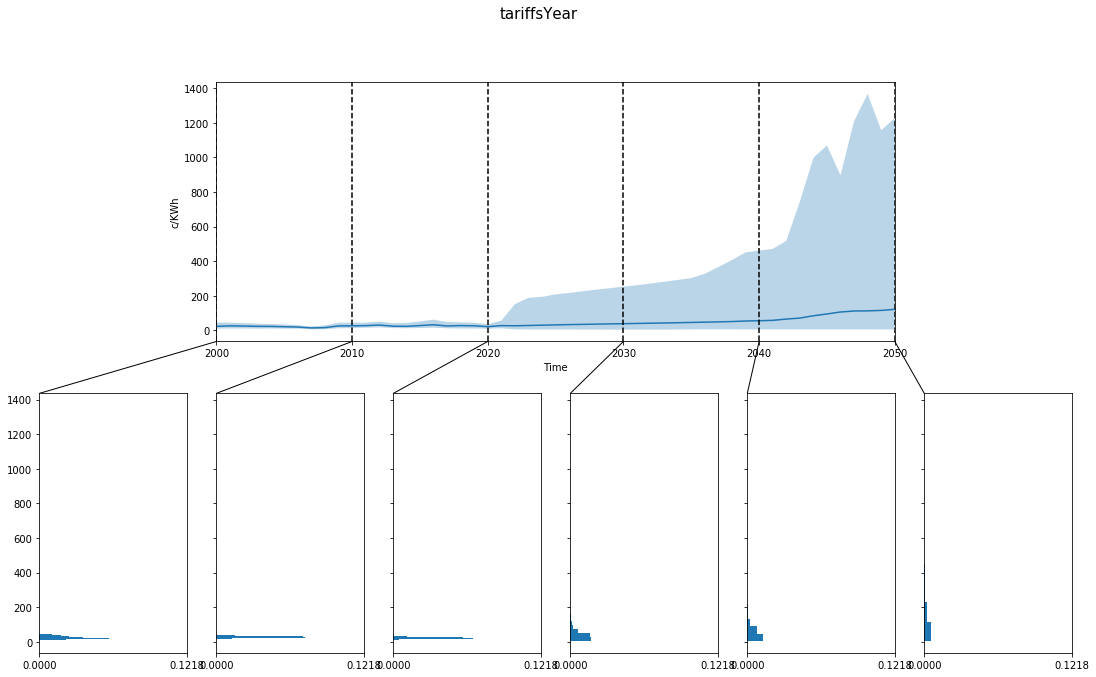

In [314]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.HIST,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "c/KWh"}, legend=True,
                                 fill=True, plot_type=PlotType.ENVELOPE)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')


In [261]:
from EMAworkbench.ema_workbench.analysis import prim
from EMAworkbench.ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);
 
x = exp
#y = out_avg_ooi > 20

y = target_at_year( outcomes_filtered, ooi, 2035, 20, True) #False is below target

prim_alg = prim.Prim(x, y, threshold=.05, threshold_type=prim.ABOVE)
box1 = prim_alg.find_box()

[MainProcess/INFO] 49152 points remaining, containing 43137 cases of interest
C:\Users\angel\Documents\GitHub\gr4sp\experiments\EMAworkbench\ema_workbench\analysis\scenario_discovery_util.py:226: RuntimeWarning: invalid value encountered in less_equal
  logical = (boxlim_numbered.loc[0, :].values <= x_numbered.values) &\
C:\Users\angel\Documents\GitHub\gr4sp\experiments\EMAworkbench\ema_workbench\analysis\scenario_discovery_util.py:227: RuntimeWarning: invalid value encountered in less_equal
  (x_numbered.values <= boxlim_numbered.loc[1, :].values)
C:\Users\angel\Documents\GitHub\gr4sp\experiments\EMAworkbench\ema_workbench\analysis\scenario_discovery_util.py:306: RuntimeWarning: invalid value encountered in long_scalars
  p = Hj / Tj
C:\Users\angel\Anaconda3\lib\site-packages\scipy\stats\_discrete_distns.py:47: RuntimeWarning: invalid value encountered in greater_equal
  return (n >= 0) & (p >= 0) & (p <= 1)
C:\Users\angel\Anaconda3\lib\site-packages\scipy\stats\_discrete_distns.py:47

AssertionError: 

In [ ]:
box1.inspect_tradeoff()

In [ ]:
%matplotlib inline
box_1 = box1.inspect(21)
box_1 = box1.inspect(21, style='graph')

In [ ]:
box1.select(21)
fig = box1.show_pairs_scatter(21)
plt.show()

## Primary Spot Production

In [315]:
# Subset Sool levers/uncertainties
selected_uncertainties = list(['annualCpi','priceChangePercentageWind','priceChangePercentageWater',
                        'semiScheduleMinCapMarketGen'])    

selected_uncertainties = uncertainties

ooi = 'primarySpotProductionYear'
data = outcomes_filtered[ooi]

num_exp = len(data)
out_avg_ooi = np.zeros(num_exp)

for i in range(num_exp):
    out_avg_ooi[i] = data[i].mean()

exp = pd.DataFrame(experiments)

exp = exp.loc[ :, selected_uncertainties] 

### Open Exploration: Visual Analysis

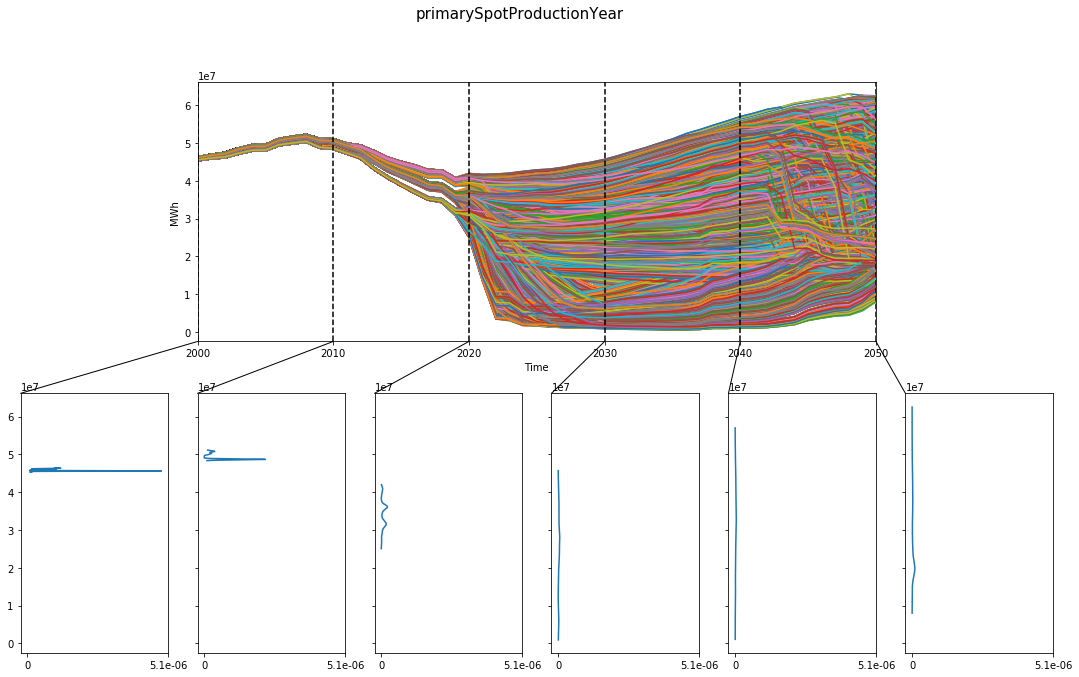

In [263]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "MWh"}, legend=True,
                                 fill=False, plot_type=PlotType.ENV_LIN)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_line_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

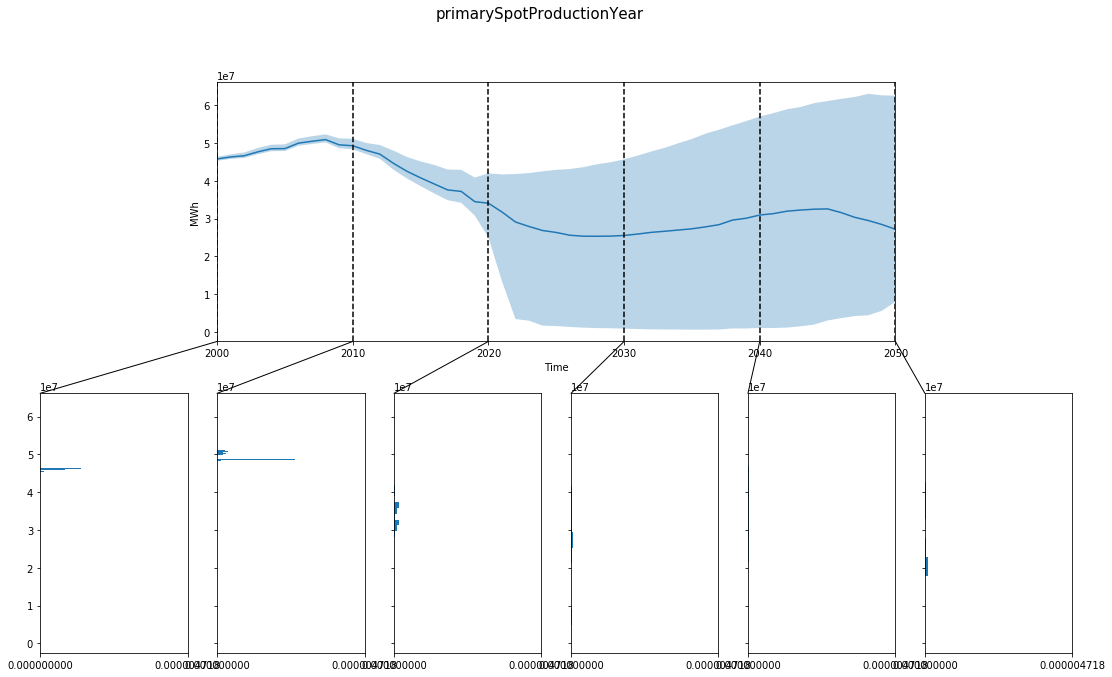

In [316]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.HIST,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "MWh"}, legend=True,
                                 fill=True, plot_type=PlotType.ENVELOPE)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

In [39]:
from EMAworkbench.ema_workbench.analysis import prim
from EMAworkbench.ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);
 
x = exp
#y = out_avg_ooi > 40000000
y = target_at_year( outcomes_filtered, ooi, 2035, 40000000, False) #False is below target

prim_alg = prim.Prim(x, y, threshold=0.3)
box1 = prim_alg.find_box()

[MainProcess/INFO] 49152 points remaining, containing 43619 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.6079508463541666, coverage: 0.6850684334808226, density: 1.0 restricted_dimensions: 2


In [ ]:
box1.inspect_tradeoff()

In [ ]:
%matplotlib inline
box_1 = box1.inspect(2)
box_1 = box1.inspect(2, style='graph')

In [ ]:
box1.select(2)
fig = box1.show_pairs_scatter(2)
plt.show()

## Secondary Spot Production

In [317]:
# Subset Sool levers/uncertainties
selected_uncertainties = list(['annualCpi','priceChangePercentageWind','priceChangePercentageWater',
                        'semiScheduleMinCapMarketGen'])    

selected_uncertainties = uncertainties

ooi = 'secondarySpotProductionYear'
data = outcomes_filtered[ooi]

num_exp = len(data)
out_avg_ooi = np.zeros(num_exp)

for i in range(num_exp):
    out_avg_ooi[i] = data[i].mean()

exp = pd.DataFrame(experiments)

exp = exp.loc[ :, selected_uncertainties] 

### Open Exploration: Visual Analysis

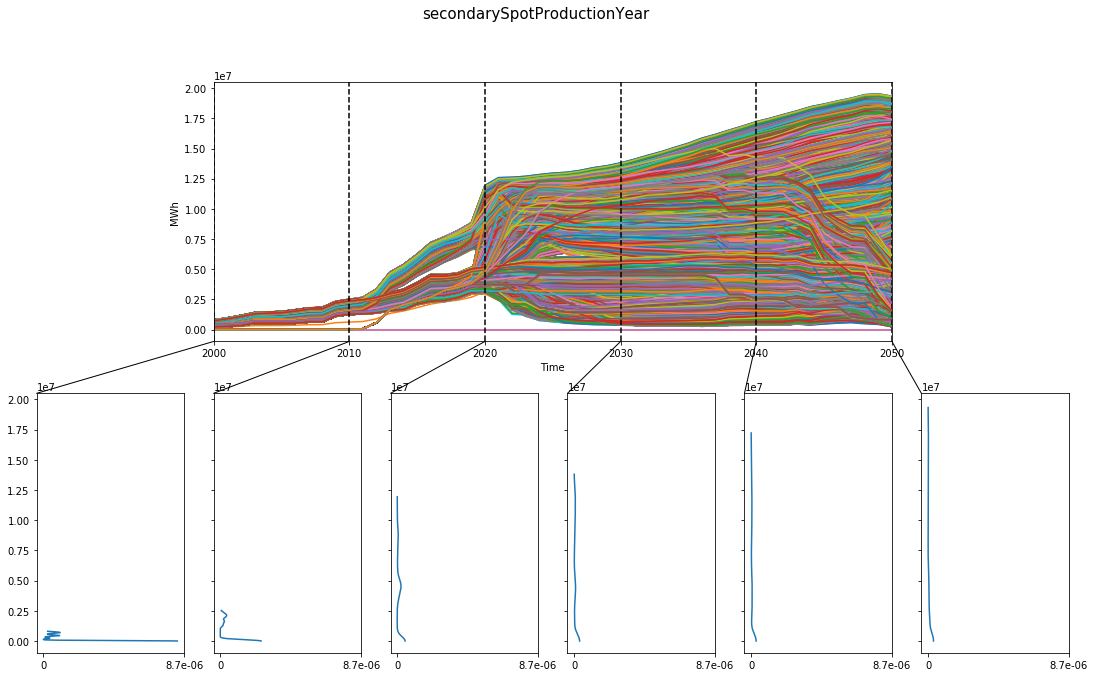

In [266]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "MWh"}, legend=True,
                                 fill=False, plot_type=PlotType.ENV_LIN)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_line_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

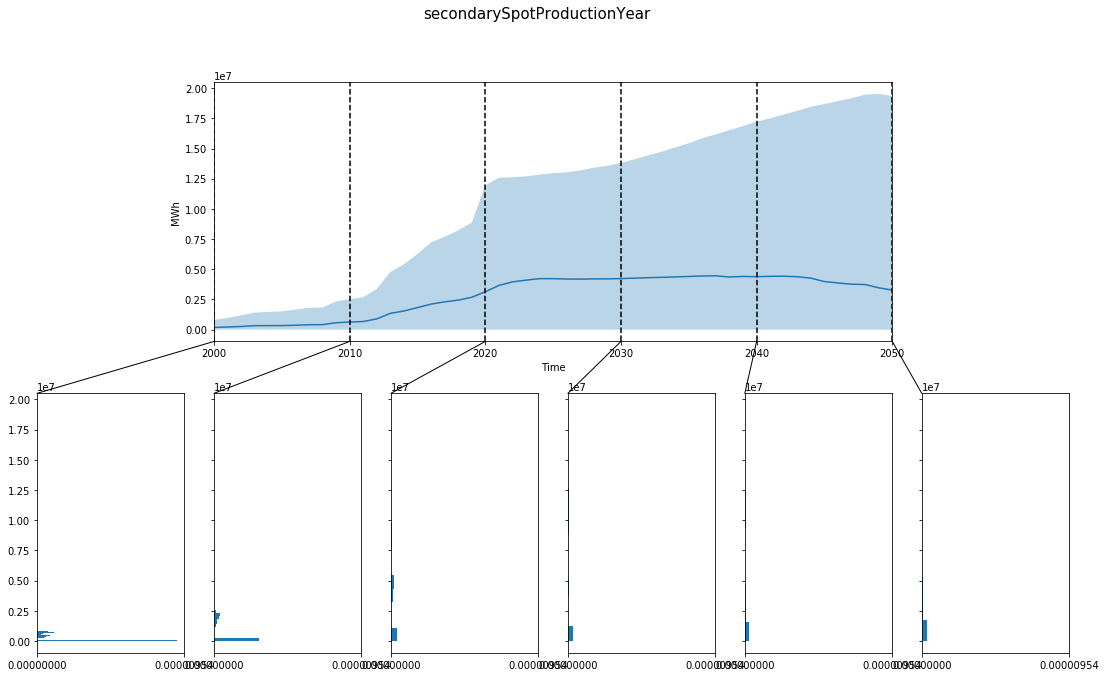

In [318]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.HIST,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "MWh"}, legend=True,
                                 fill=True, plot_type=PlotType.ENVELOPE)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

In [ ]:
from EMAworkbench.ema_workbench.analysis import prim
from EMAworkbench.ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);
 
x = exp
#y = out_avg_ooi > 40000000
y = target_at_year( outcomes_filtered, ooi, 2035, 40000000, False) #False is below target

prim_alg = prim.Prim(x, y, threshold=0.3)
box1 = prim_alg.find_box()

In [ ]:
box1.inspect_tradeoff()

In [ ]:
%matplotlib inline
box_1 = box1.inspect(2)
box_1 = box1.inspect(2, style='graph')

In [ ]:
box1.select(2)
fig = box1.show_pairs_scatter(2)
plt.show()

## Rooftop PV Production

In [319]:
# Subset Sool levers/uncertainties
selected_uncertainties = list(['annualCpi','priceChangePercentageWind','priceChangePercentageWater',
                        'semiScheduleMinCapMarketGen'])    

selected_uncertainties = uncertainties

ooi = 'rooftopPVProductionYear'
data = outcomes_filtered[ooi]

num_exp = len(data)
out_avg_ooi = np.zeros(num_exp)

for i in range(num_exp):
    out_avg_ooi[i] = data[i].mean()

exp = pd.DataFrame(experiments)

exp = exp.loc[ :, selected_uncertainties] 

### Open Exploration: Visual Analysis

[MainProcess/WARNING] singular matrix


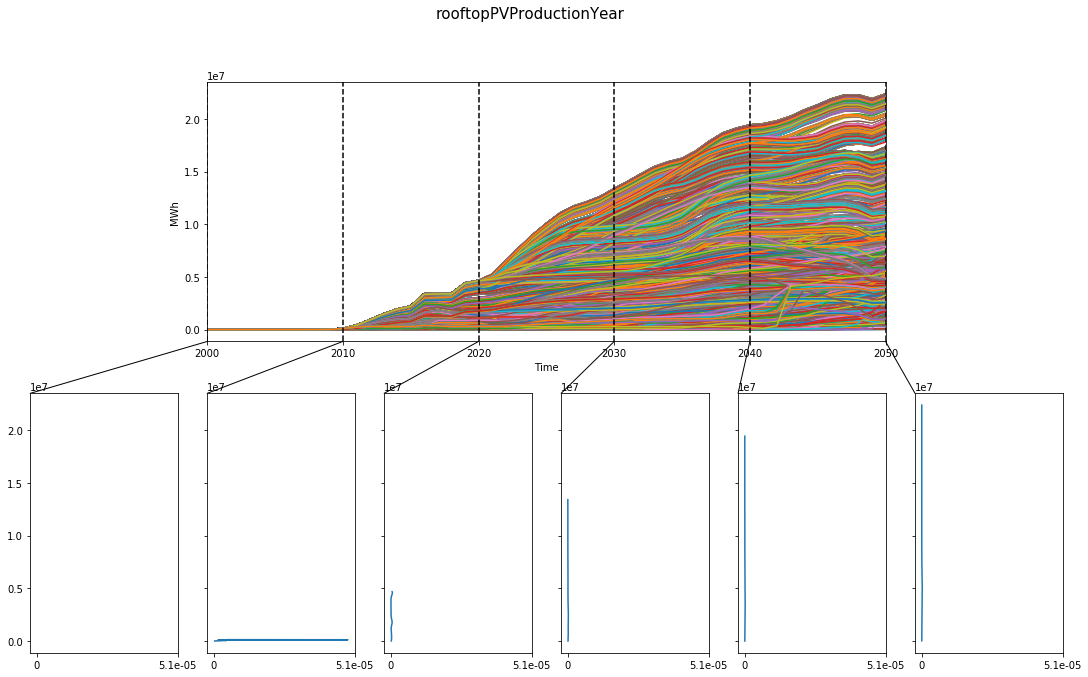

In [276]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "MWh"}, legend=True,
                                 fill=False, plot_type=PlotType.ENV_LIN)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_line_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

[MainProcess/WARNING] singular matrix


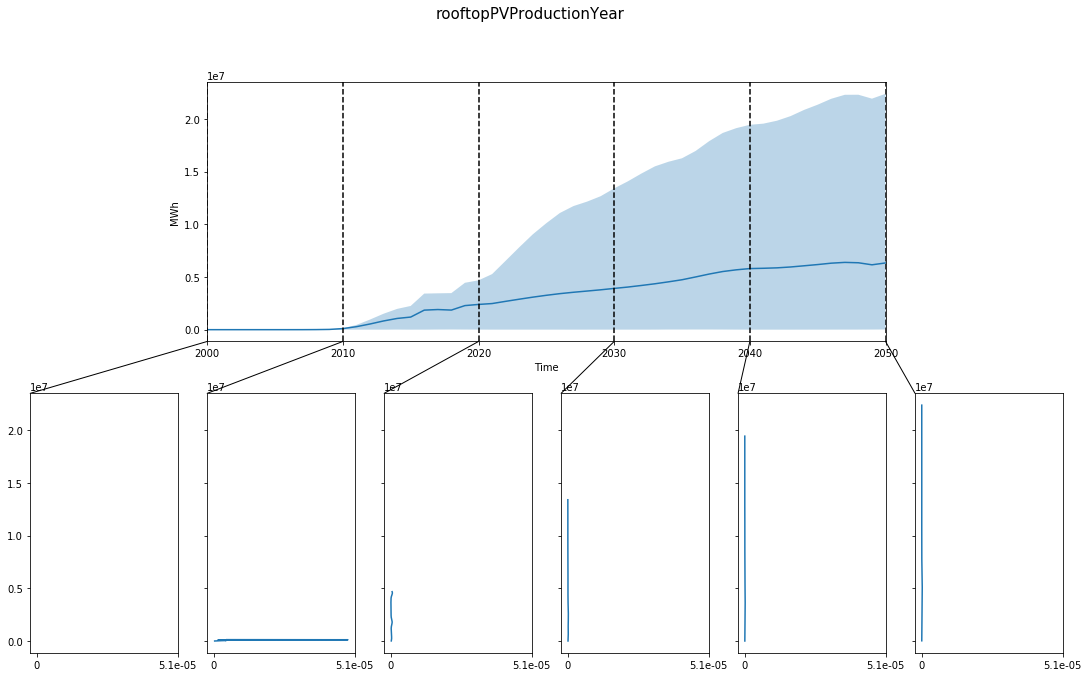

In [321]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "MWh"}, legend=True,
                                 fill=True, plot_type=PlotType.ENVELOPE)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

In [ ]:
from EMAworkbench.ema_workbench.analysis import prim
from EMAworkbench.ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);
 
x = exp
#y = out_avg_ooi > 40000000
y = target_at_year( outcomes_filtered, ooi, 2035, 40000000, False) #False is below target

prim_alg = prim.Prim(x, y, threshold=0.3)
box1 = prim_alg.find_box()

In [ ]:
box1.inspect_tradeoff()

In [ ]:
%matplotlib inline
box_1 = box1.inspect(2)
box_1 = box1.inspect(2, style='graph')

In [ ]:
box1.select(2)
fig = box1.show_pairs_scatter(2)
plt.show()

In [ ]:
box1.select(2)
fig = box1.show_pairs_scatter(2)
plt.show()

## Off Spot Production

In [10]:
# Subset Sool levers/unceratinties
selected_uncertainties = list(['annualCpi','priceChangePercentageWind','priceChangePercentageWater',
                        'semiScheduleMinCapMarketGen'])    

selected_uncertainties = uncertainties

ooi = 'offSpotProductionYear'
data = outcomes_filtered[ooi]

num_exp = len(data)
out_avg_ooi = np.zeros(num_exp)

for i in range(num_exp):
    out_avg_ooi[i] = data[i].mean()

exp = pd.DataFrame(experiments)

exp = exp.loc[ :, selected_uncertainties] 

### Open Exploration: Visual Analysis

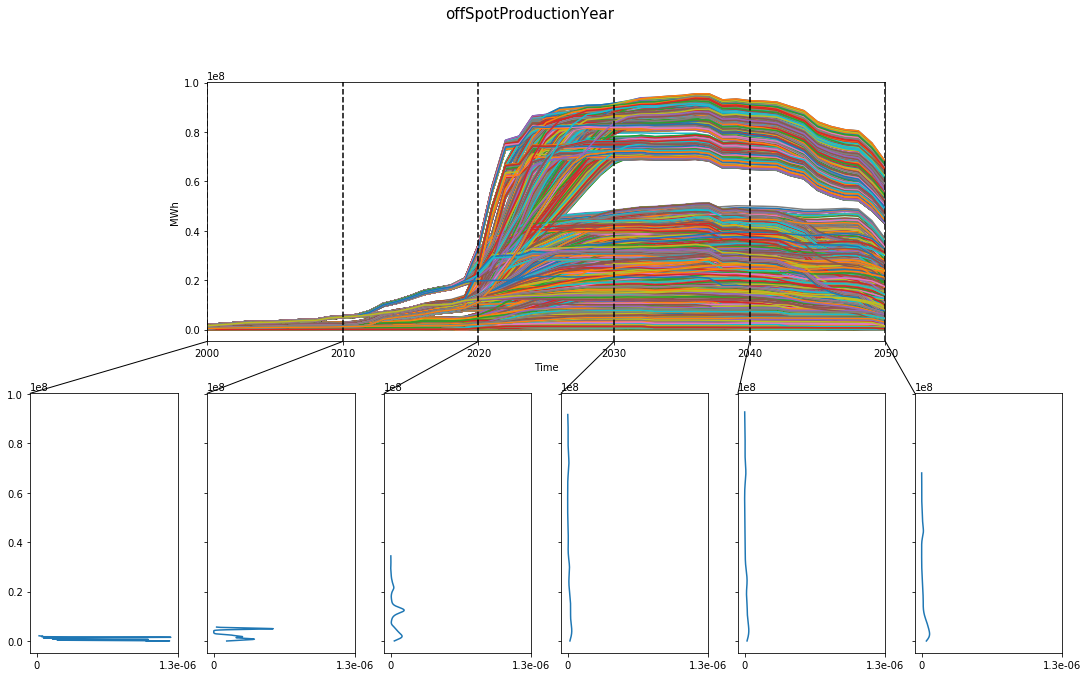

In [279]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "MWh"}, legend=True,
                                 fill=False, plot_type=PlotType.ENV_LIN)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_line_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

Densities (PDF): {'0.0 to 192460.3': '0.000', '192460.3 to 384920.6': '0.000', '384920.6 to 577380.9': '0.000', '577380.9 to 769841.3': '0.000', '769841.3 to 962301.6': '0.000', '962301.6 to 1154761.9': '0.000', '1154761.9 to 1347222.2': '0.000', '1347222.2 to 1539682.5': '0.000', '1539682.5 to 1732142.8': '0.000', '1732142.8 to 1924603.1': '0.000', '1924603.1 to 2117063.5': '0.000'}
% in Bin: {'0.0 to 192460.3': '25.7%', '192460.3 to 384920.6': '5.7%', '384920.6 to 577380.9': '11.2%', '577380.9 to 769841.3': '14.5%', '769841.3 to 962301.6': '2.6%', '962301.6 to 1154761.9': '6.3%', '1154761.9 to 1347222.2': '0.1%', '1347222.2 to 1539682.5': '21.8%', '1539682.5 to 1732142.8': '10.3%', '1732142.8 to 1924603.1': '1.0%', '1924603.1 to 2117063.5': '0.7%'}

Densities (PDF): {'942.9 to 513434.6': '0.000', '513434.6 to 1025926.4': '0.000', '1025926.4 to 1538418.1': '0.000', '1538418.1 to 2050909.9': '0.000', '2050909.9 to 2563401.6': '0.000', '2563401.6 to 3075893.4': '0.000', '3075893.4 to 35

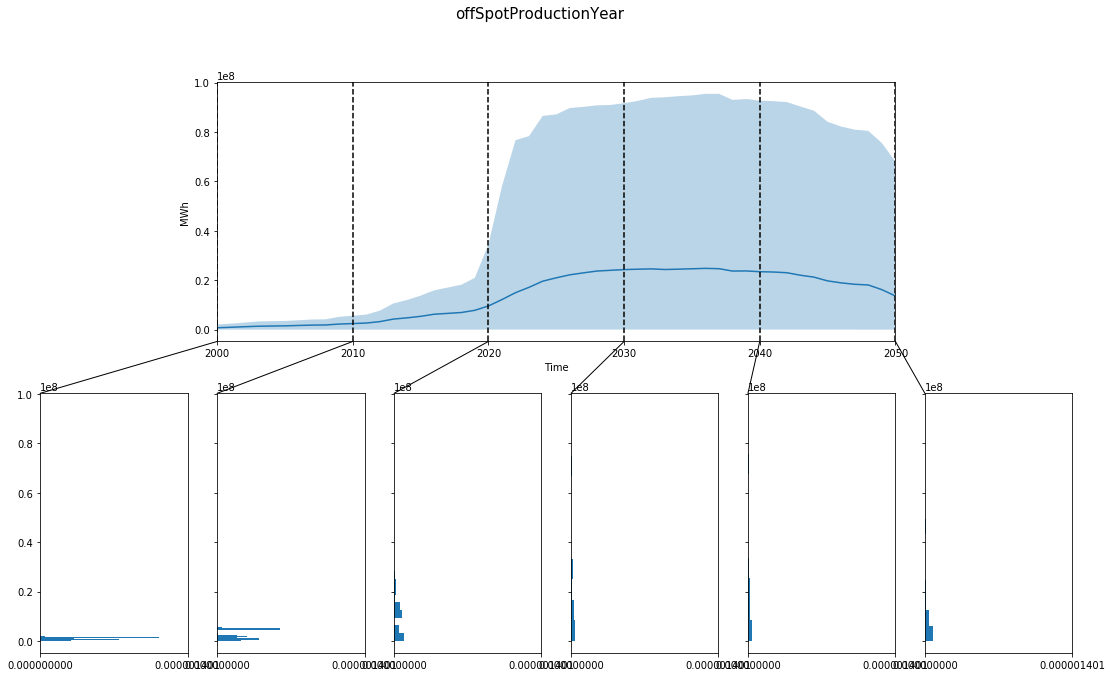

In [14]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.HIST,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "MWh"}, legend=True,
                                 fill=True, plot_type=PlotType.ENVELOPE)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

In [13]:
from EMAworkbench.ema_workbench.analysis import prim
from EMAworkbench.ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);
 
x = exp
#y = out_avg_ooi > 40000000
y = target_at_year( outcomes_filtered, ooi, 2035, 40000000, False) #False is below target

prim_alg = prim.Prim(x, y, threshold=0.3)
box1 = prim_alg.find_box()

[MainProcess/INFO] 49152 points remaining, containing 39430 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.4420979817708333, coverage: 0.5511032208977935, density: 1.0 restricted_dimensions: 2


In [ ]:
box1.inspect_tradeoff()

In [ ]:
%matplotlib inline
box_1 = box1.inspect(2)
box_1 = box1.inspect(2, style='graph')

In [ ]:
box1.select(2)
fig = box1.show_pairs_scatter(2)
plt.show()

## Renewable Energies in the System

In [326]:
# Subset Sool levers/uncertainties
selected_uncertainties = list(['annualCpi','priceChangePercentageWind','priceChangePercentageWater',
                        'semiScheduleMinCapMarketGen'])    

selected_uncertainties = uncertainties

ooi = 'renewableContributionYear'
data = outcomes_filtered[ooi]

num_exp = len(data)
out_avg_ooi = np.zeros(num_exp)

for i in range(num_exp):
    out_avg_ooi[i] = data[i].mean()

exp = pd.DataFrame(experiments)

exp = exp.loc[ :, selected_uncertainties] 

### Open Exploration: Visual Analysis

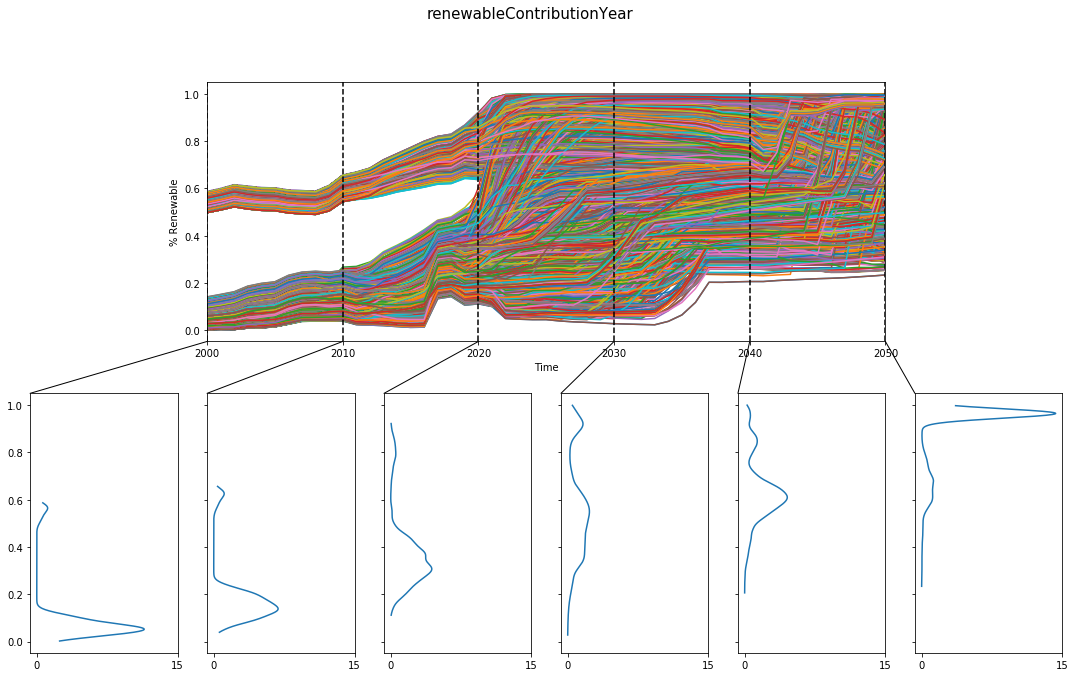

In [282]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "% Renewable"}, legend=True,
                                 fill=False, plot_type=PlotType.ENV_LIN)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_line_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

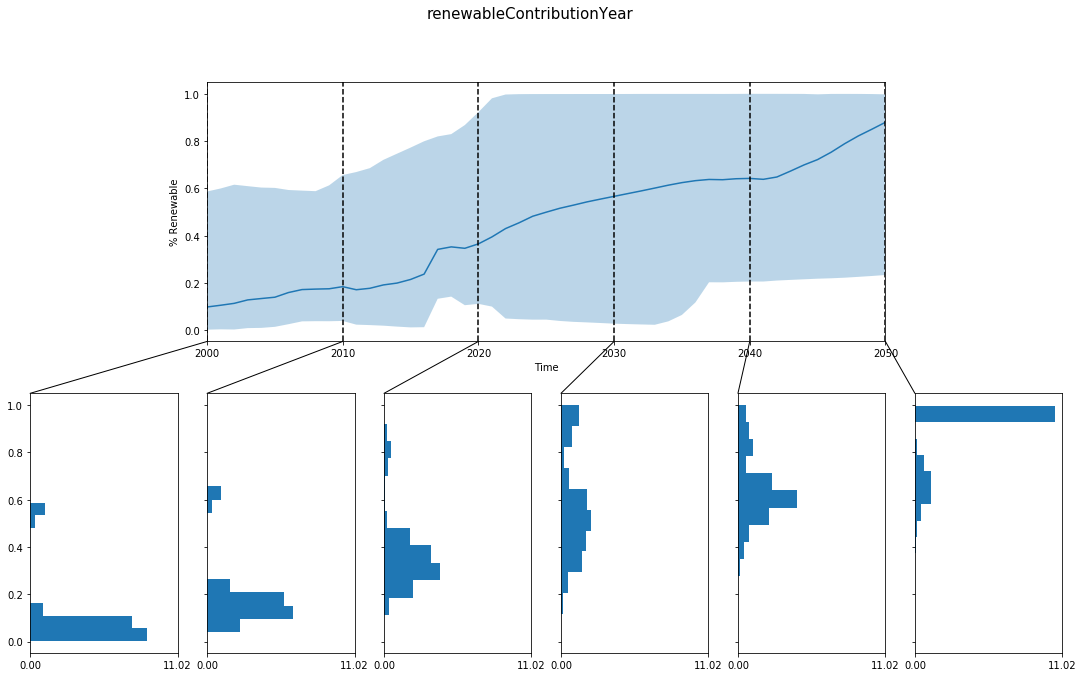

In [327]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.HIST,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "% Renewable"}, legend=True,
                                 fill=True, plot_type=PlotType.ENVELOPE)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

In [ ]:
from EMAworkbench.ema_workbench.analysis import prim
from EMAworkbench.ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);
 
x = exp
#y = out_avg_ooi > 40000000
y = target_at_year( outcomes_filtered, ooi, 2035, 40000000, False) #False is below target

prim_alg = prim.Prim(x, y, threshold=0.3)
box1 = prim_alg.find_box()

In [ ]:
box1.select(2)
fig = box1.show_pairs_scatter(2)
plt.show()

In [ ]:
box1.select(2)
fig = box1.show_pairs_scatter(2)
plt.show()

## Coal Production

In [328]:
# Subset Sool levers/uncertainties
selected_uncertainties = list(['annualCpi','priceChangePercentageWind','priceChangePercentageWater',
                        'semiScheduleMinCapMarketGen'])    

selected_uncertainties = uncertainties

ooi = 'coalProductionYear'
data = outcomes_filtered[ooi]

num_exp = len(data)
out_avg_ooi = np.zeros(num_exp)

for i in range(num_exp):
    out_avg_ooi[i] = data[i].mean()

exp = pd.DataFrame(experiments)

exp = exp.loc[ :, selected_uncertainties] 

### Open Exploration: Visual Analysis

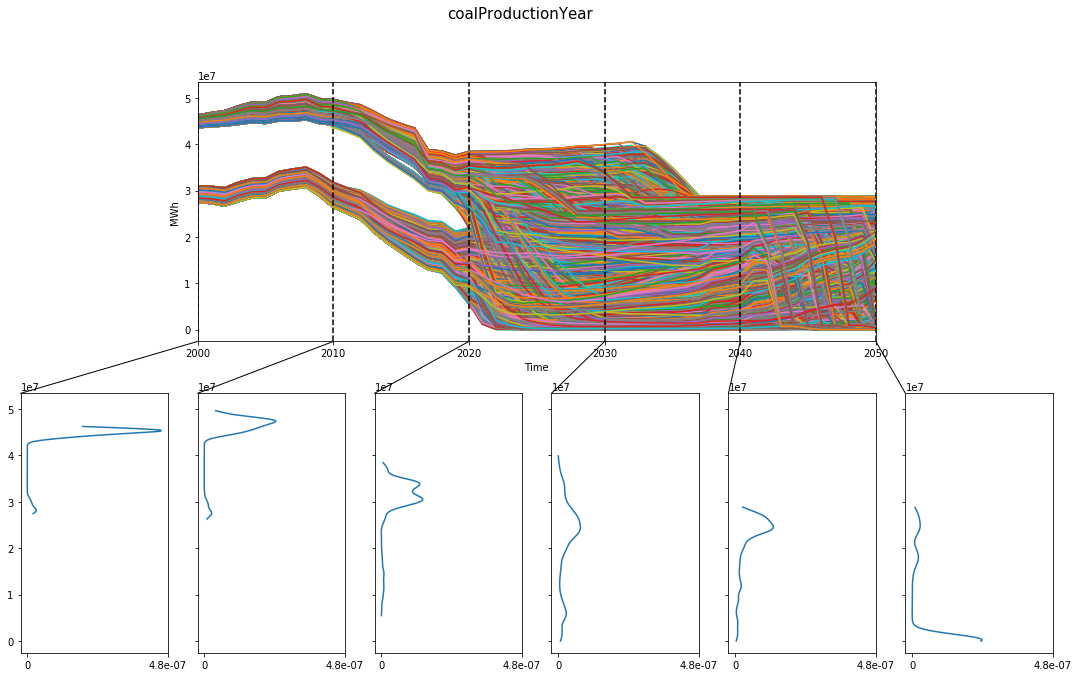

In [285]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "MWh"}, legend=True,
                                 fill=False, plot_type=PlotType.ENV_LIN)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_line_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

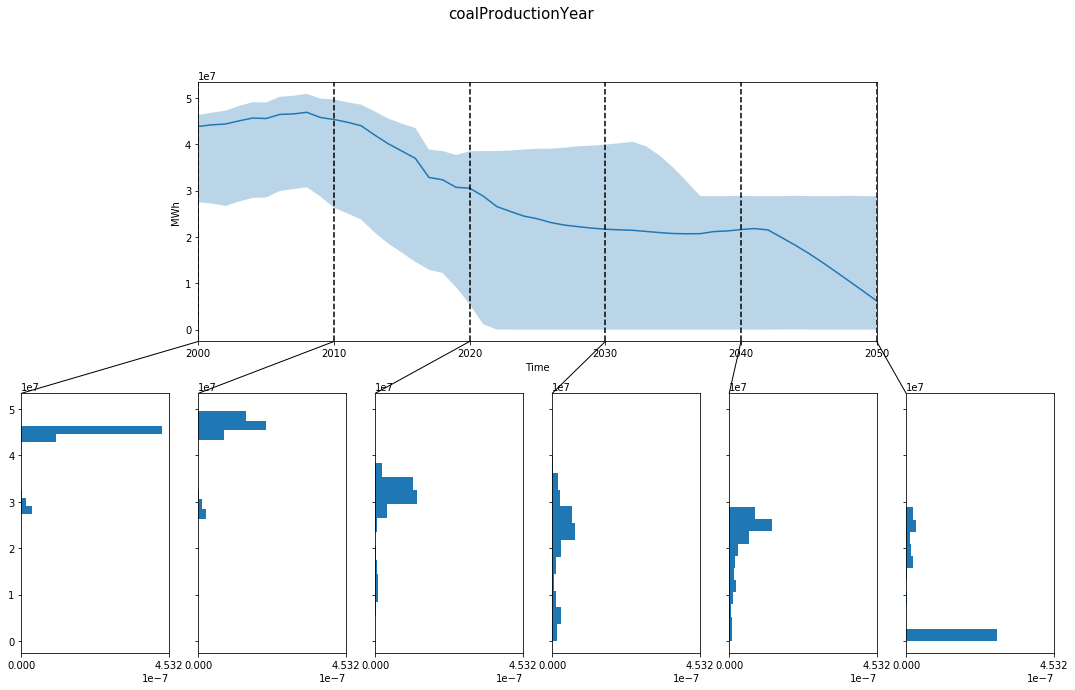

In [329]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.HIST,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "MWh"}, legend=True,
                                 fill=True, plot_type=PlotType.ENVELOPE)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

In [ ]:
from EMAworkbench.ema_workbench.analysis import prim
from EMAworkbench.ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);
 
x = exp
#y = out_avg_ooi > 40000000
y = target_at_year( outcomes_filtered, ooi, 2035, 40000000, False) #False is below target

prim_alg = prim.Prim(x, y, threshold=0.3)
box1 = prim_alg.find_box()

In [ ]:
box1.inspect_tradeoff()

In [ ]:
%matplotlib inline
box_1 = box1.inspect(2)
box_1 = box1.inspect(2, style='graph')

In [ ]:
box1.select(2)
fig = box1.show_pairs_scatter(2)
plt.show()

## Water Production

In [330]:
# Subset Sool levers
selected_uncertainties = list(['annualCpi','priceChangePercentageWind','priceChangePercentageWater',
                        'semiScheduleMinCapMarketGen'])    

selected_uncertainties = uncertainties

ooi = 'waterProductionYear'
data = outcomes_filtered[ooi]

num_exp = len(data)
out_avg_ooi = np.zeros(num_exp)

for i in range(num_exp):
    out_avg_ooi[i] = data[i].mean()

exp = pd.DataFrame(experiments)

exp = exp.loc[ :, selected_uncertainties] 

### Open Exploration: Visual Analysis

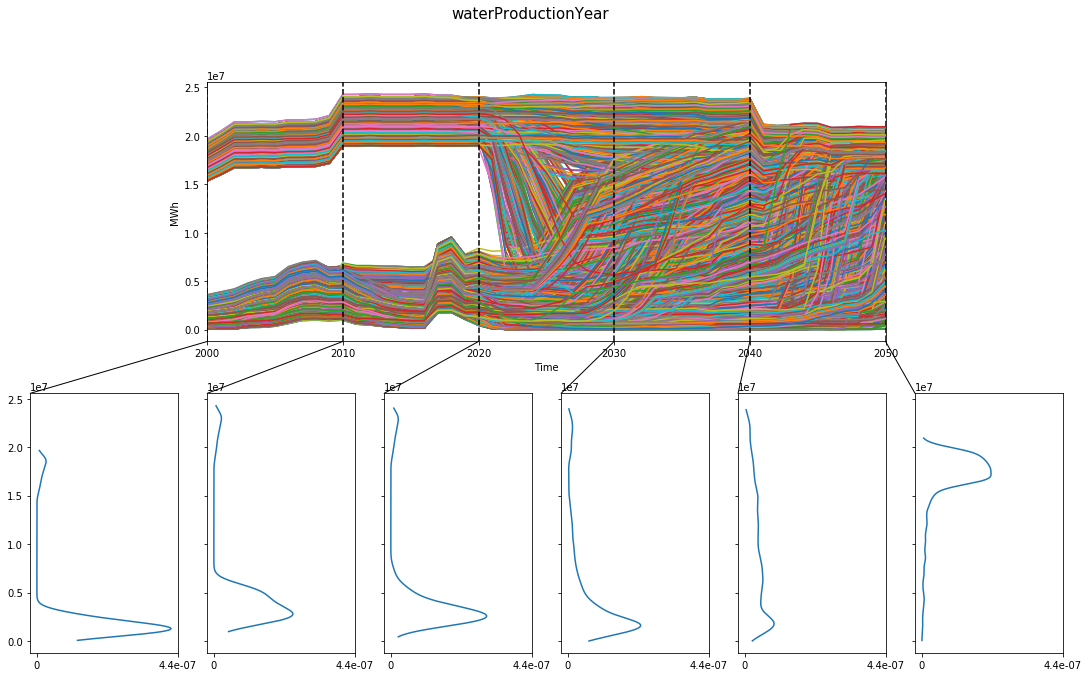

In [288]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "MWh"}, legend=True,
                                 fill=False, plot_type=PlotType.ENV_LIN)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_line_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

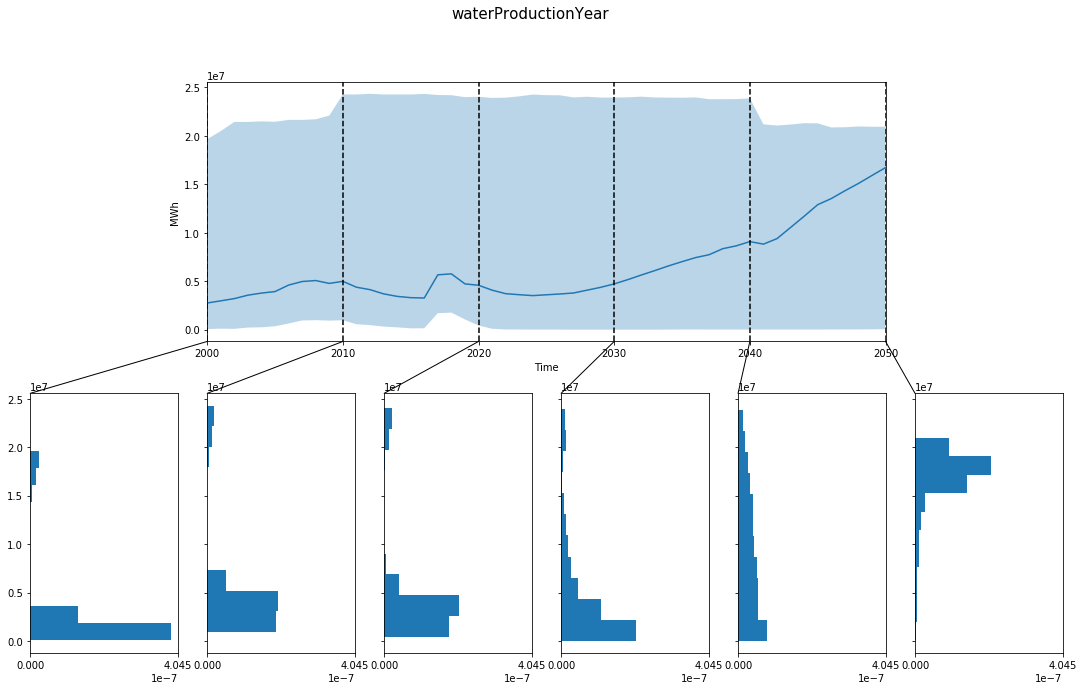

In [331]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.HIST,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "MWh"}, legend=True,
                                 fill=True, plot_type=PlotType.ENVELOPE)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

In [ ]:
from EMAworkbench.ema_workbench.analysis import prim
from EMAworkbench.ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);
 
x = exp
#y = out_avg_ooi > 40000000
y = target_at_year( outcomes_filtered, ooi, 2035, 40000000, False) #False is below target

prim_alg = prim.Prim(x, y, threshold=0.3)
box1 = prim_alg.find_box()

In [ ]:
box1.inspect_tradeoff()

In [ ]:
%matplotlib inline
box_1 = box1.inspect(2)
box_1 = box1.inspect(2, style='graph')

In [ ]:
box1.select(2)
fig = box1.show_pairs_scatter(2)
plt.show()

## Wind Production

In [332]:
# Subset Sool levers
selected_uncertainties = list(['annualCpi','priceChangePercentageWind','priceChangePercentageWater',
                        'semiScheduleMinCapMarketGen'])    

selected_uncertainties = uncertainties

ooi = 'windProductionYear'
data = outcomes_filtered[ooi]

num_exp = len(data)
out_avg_ooi = np.zeros(num_exp)

for i in range(num_exp):
    out_avg_ooi[i] = data[i].mean()

exp = pd.DataFrame(experiments)

exp = exp.loc[ :, selected_uncertainties] 

### Open Exploration: Visual Analysis

[MainProcess/WARNING] singular matrix


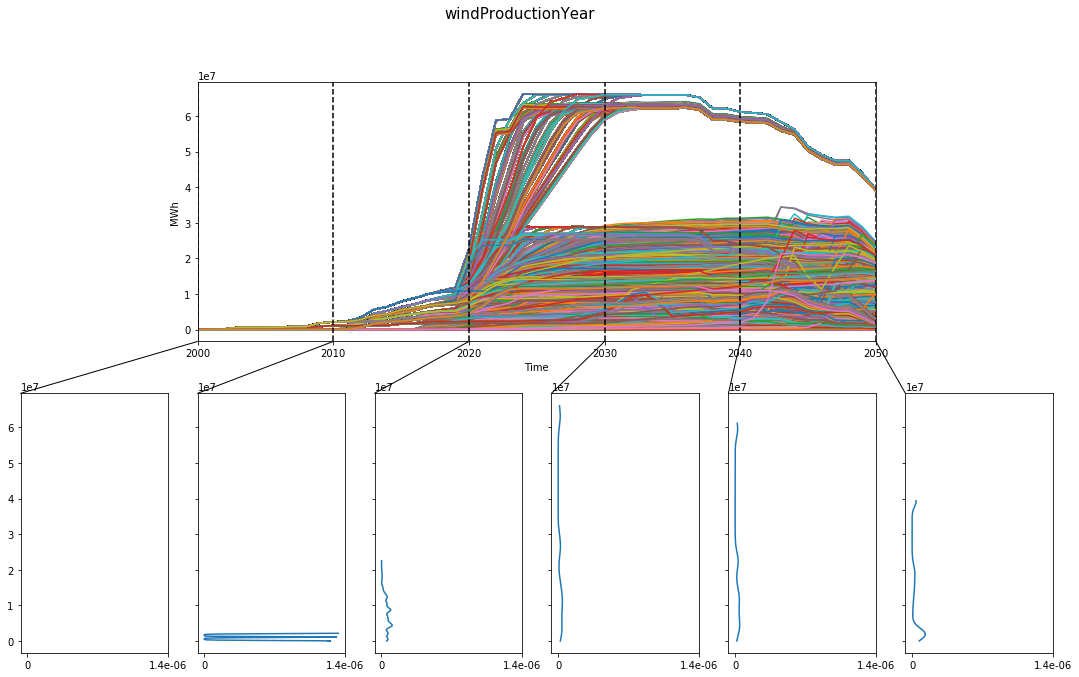

In [291]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "MWh"}, legend=True,
                                 fill=False, plot_type=PlotType.ENV_LIN)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_line_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

[MainProcess/WARNING] singular matrix


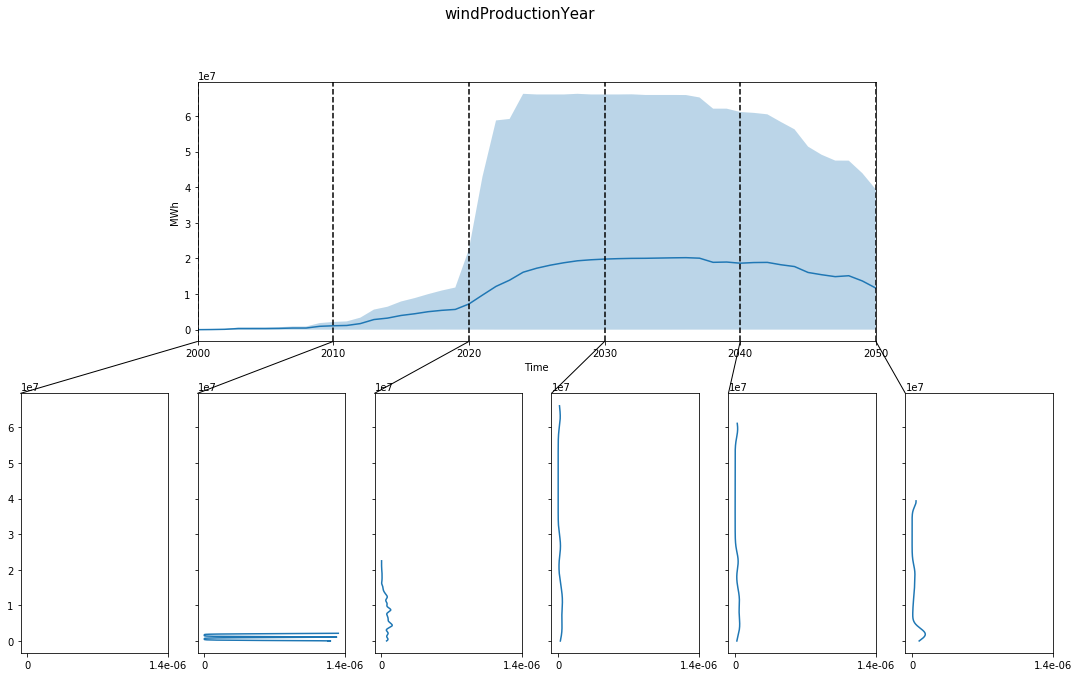

In [334]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "MWh"}, legend=True,
                                 fill=True, plot_type=PlotType.ENVELOPE)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

In [ ]:
from EMAworkbench.ema_workbench.analysis import prim
from EMAworkbench.ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);
 
x = exp
#y = out_avg_ooi > 40000000
y = target_at_year( outcomes_filtered, ooi, 2035, 40000000, False) #False is below target

prim_alg = prim.Prim(x, y, threshold=0.3)
box1 = prim_alg.find_box()

In [ ]:
box1.inspect_tradeoff()

In [ ]:
%matplotlib inline
box_1 = box1.inspect(2)
box_1 = box1.inspect(2, style='graph')

In [ ]:
box1.select(2)
fig = box1.show_pairs_scatter(2)
plt.show()

## Gas Production

In [335]:
# Subset Sool levers
selected_uncertainties = list(['annualCpi','priceChangePercentageWind','priceChangePercentageWater',
                        'semiScheduleMinCapMarketGen'])    

selected_uncertainties = uncertainties

ooi = 'gasProductionYear'
data = outcomes_filtered[ooi]

num_exp = len(data)
out_avg_ooi = np.zeros(num_exp)

for i in range(num_exp):
    out_avg_ooi[i] = data[i].mean()

exp = pd.DataFrame(experiments)

exp = exp.loc[ :, selected_uncertainties] 

### Open Exploration: Visual Analysis

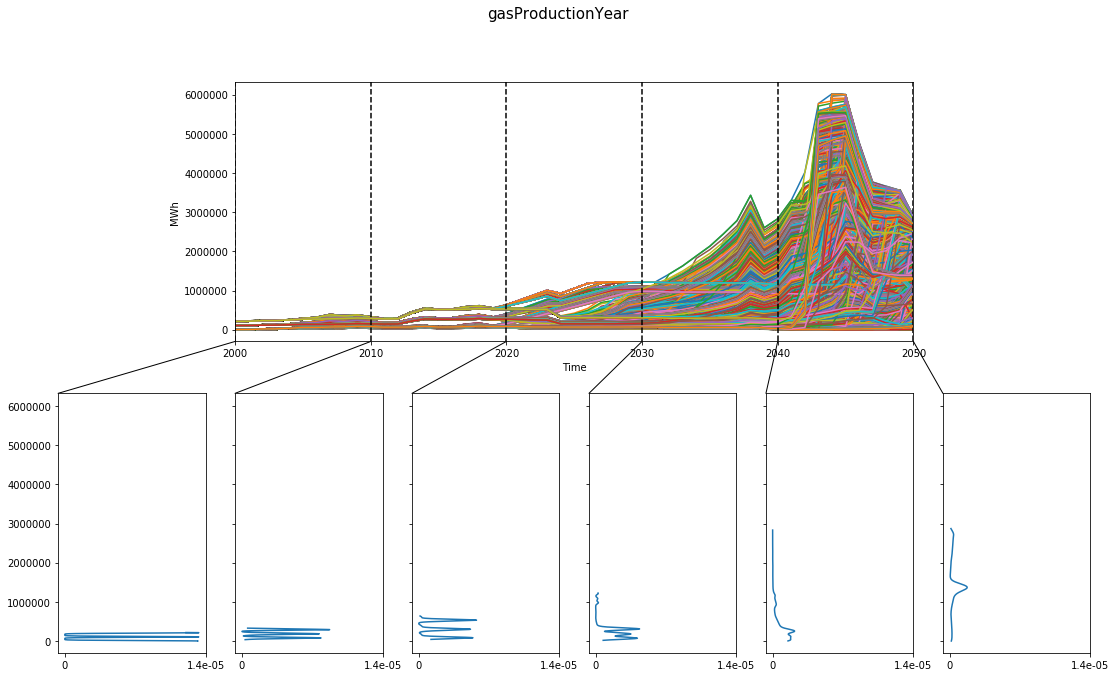

In [294]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "MWh"}, legend=True,
                                 fill=False, plot_type=PlotType.ENV_LIN)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_line_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

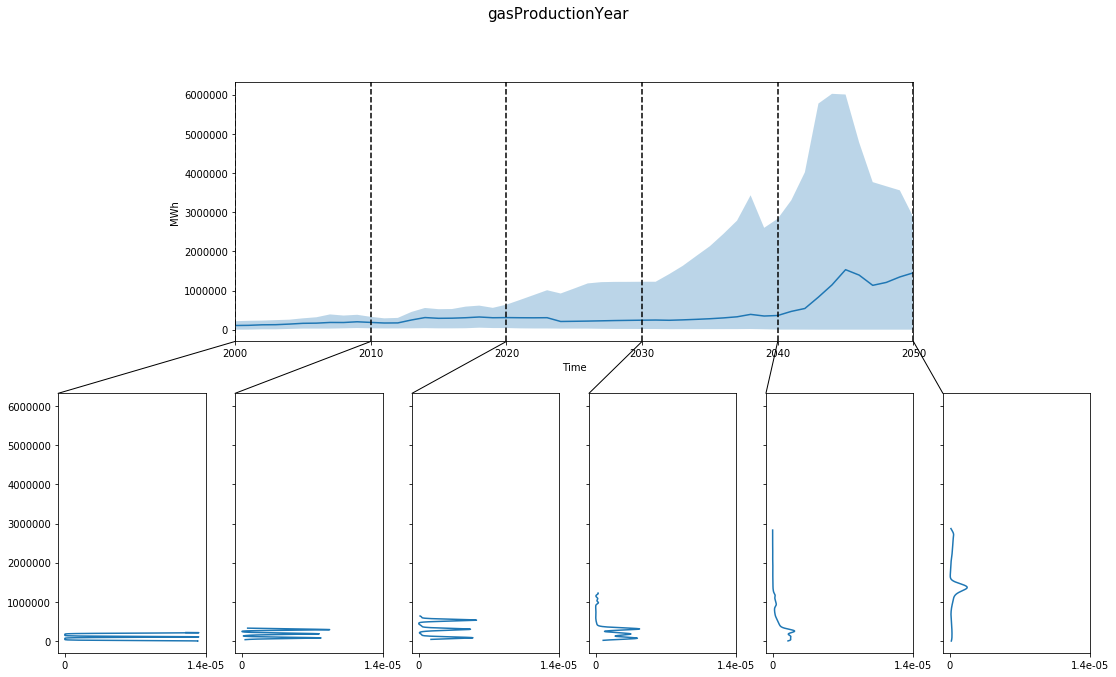

In [337]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "MWh"}, legend=True,
                                 fill=True, plot_type=PlotType.ENVELOPE)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

In [ ]:
from EMAworkbench.ema_workbench.analysis import prim
from EMAworkbench.ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);
 
x = exp
#y = out_avg_ooi > 40000000
y = target_at_year( outcomes_filtered, ooi, 2035, 40000000, False) #False is below target

prim_alg = prim.Prim(x, y, threshold=0.3)
box1 = prim_alg.find_box()

In [ ]:
box1.inspect_tradeoff()

In [ ]:
%matplotlib inline
box_1 = box1.inspect(2)
box_1 = box1.inspect(2, style='graph')

In [ ]:
box1.select(2)
fig = box1.show_pairs_scatter(2)
plt.show()

## Solar Production

In [338]:
# Subset Sool levers
selected_uncertainties = list(['annualCpi','priceChangePercentageWind','priceChangePercentageWater',
                        'semiScheduleMinCapMarketGen'])    

selected_uncertainties = uncertainties

ooi = 'solarProductionYear'
data = outcomes_filtered[ooi]

num_exp = len(data)
out_avg_ooi = np.zeros(num_exp)

for i in range(num_exp):
    out_avg_ooi[i] = data[i].mean()

exp = pd.DataFrame(experiments)

exp = exp.loc[ :, selected_uncertainties] 

### Open Exploration: Visual Analysis

[MainProcess/WARNING] singular matrix


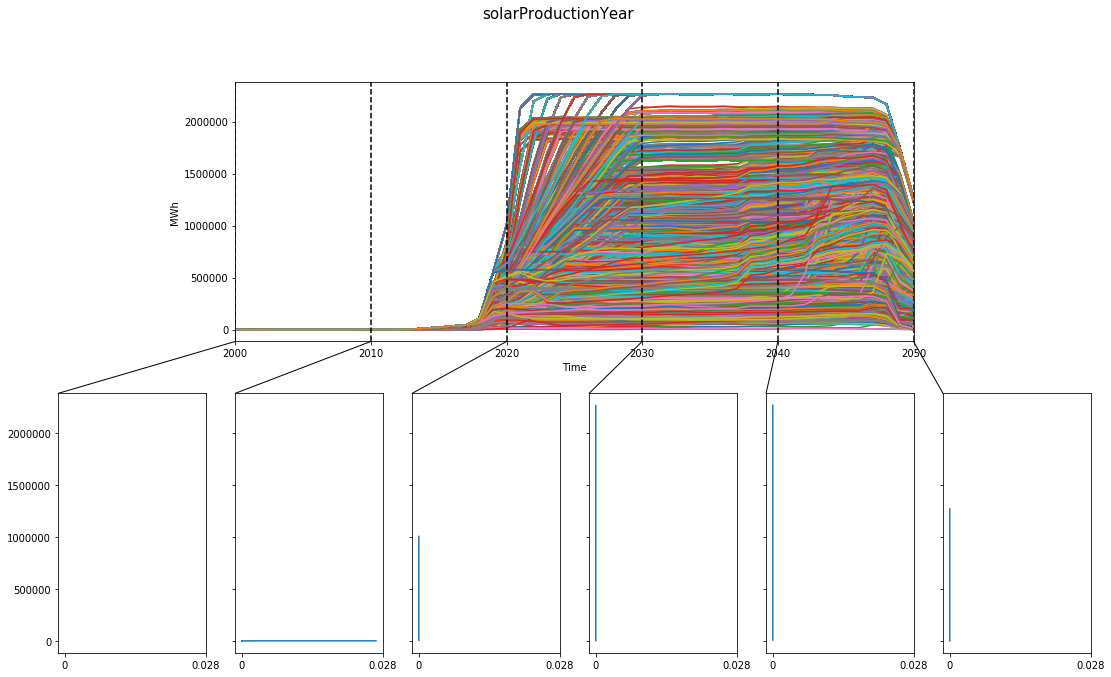

In [297]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "MWh"}, legend=True,
                                 fill=False, plot_type=PlotType.ENV_LIN)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_line_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

[MainProcess/WARNING] singular matrix


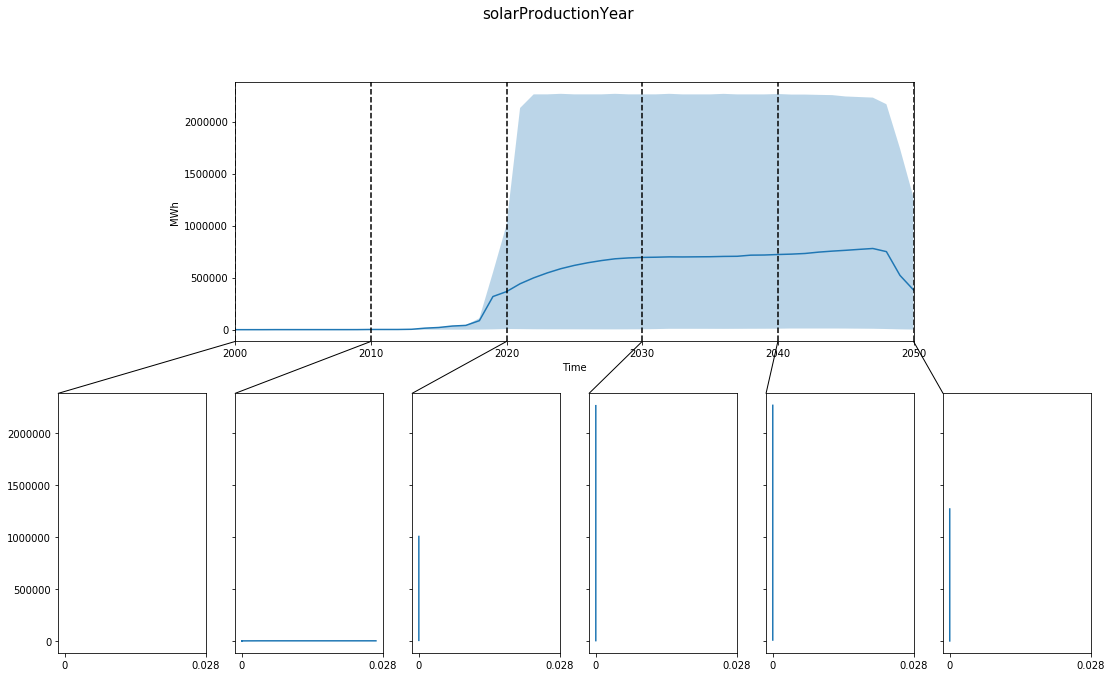

In [298]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "MWh"}, legend=True,
                                 fill=True, plot_type=PlotType.ENVELOPE)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

In [ ]:
from EMAworkbench.ema_workbench.analysis import prim
from EMAworkbench.ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);
 
x = exp
#y = out_avg_ooi > 40000000
y = target_at_year( outcomes_filtered, ooi, 2035, 40000000, False) #False is below target

prim_alg = prim.Prim(x, y, threshold=0.3)
box1 = prim_alg.find_box()

In [ ]:
box1.inspect_tradeoff()

In [ ]:
%matplotlib inline
box_1 = box1.inspect(2)
box_1 = box1.inspect(2, style='graph')

In [ ]:
box1.select(2)
fig = box1.show_pairs_scatter(2)
plt.show()

## Battery Production

In [299]:
# Subset Sool levers
selected_uncertainties = list(['annualCpi','priceChangePercentageWind','priceChangePercentageWater',
                        'semiScheduleMinCapMarketGen'])    

selected_uncertainties = uncertainties

ooi = 'BatteryProductionYear'
data = outcomes_filtered[ooi]

num_exp = len(data)
out_avg_ooi = np.zeros(num_exp)

for i in range(num_exp):
    out_avg_ooi[i] = data[i].mean()

exp = pd.DataFrame(experiments)

exp = exp.loc[ :, selected_uncertainties] 

### Open Exploration: Visual Analysis

[MainProcess/WARNING] singular matrix
[MainProcess/WARNING] singular matrix
[MainProcess/WARNING] singular matrix
[MainProcess/WARNING] singular matrix
[MainProcess/WARNING] singular matrix
[MainProcess/WARNING] singular matrix


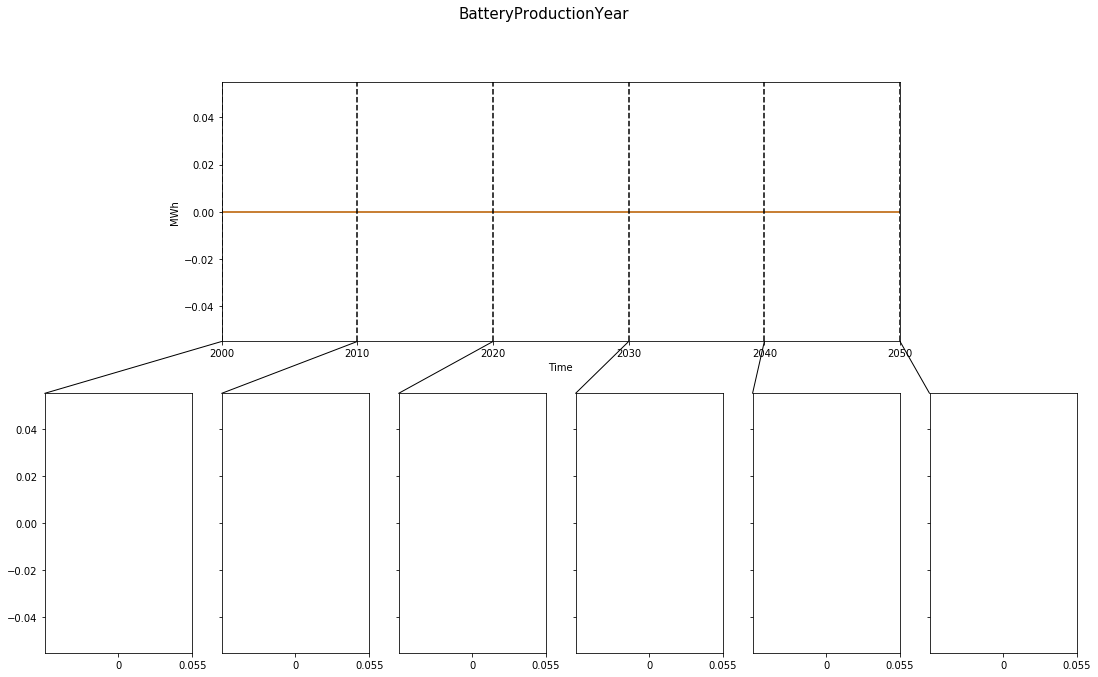

In [300]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "MWh"}, legend=True,
                                 fill=False, plot_type=PlotType.ENV_LIN)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_line_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

[MainProcess/WARNING] singular matrix
[MainProcess/WARNING] singular matrix
[MainProcess/WARNING] singular matrix
[MainProcess/WARNING] singular matrix
[MainProcess/WARNING] singular matrix
[MainProcess/WARNING] singular matrix


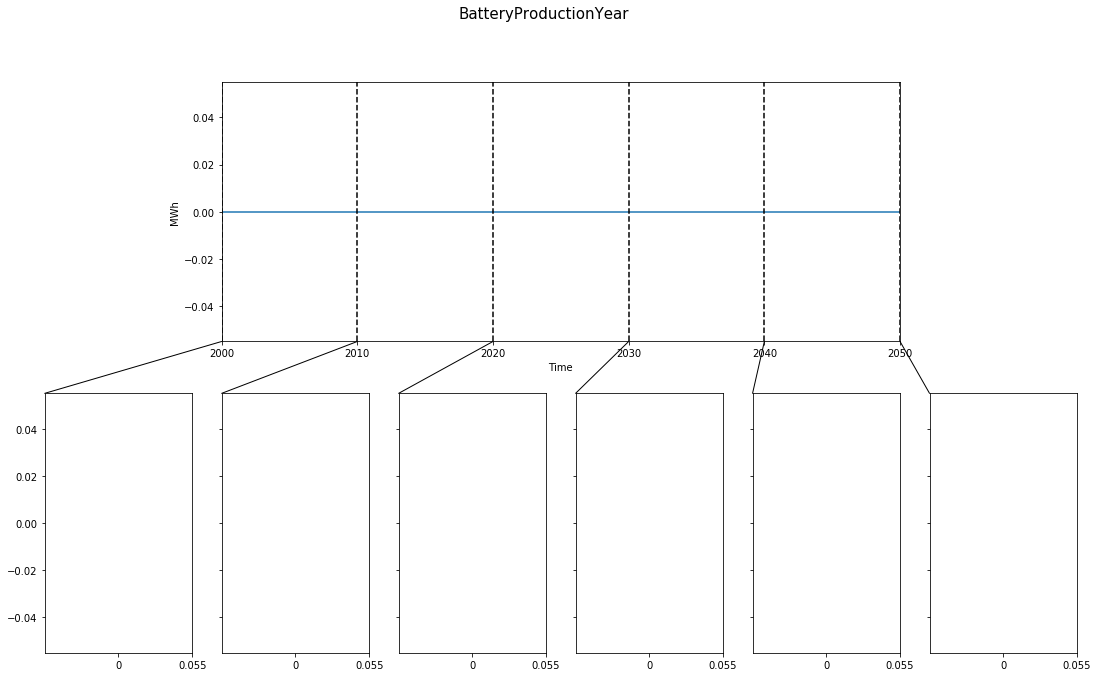

In [301]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "MWh"}, legend=True,
                                 fill=True, plot_type=PlotType.ENVELOPE)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

In [ ]:
from EMAworkbench.ema_workbench.analysis import prim
from EMAworkbench.ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);
 
x = exp
#y = out_avg_ooi > 40000000
y = target_at_year( outcomes_filtered, ooi, 2035, 40000000, False) #False is below target

prim_alg = prim.Prim(x, y, threshold=0.3)
box1 = prim_alg.find_box()

In [ ]:
box1.inspect_tradeoff()

In [ ]:
%matplotlib inline
box_1 = box1.inspect(2)
box_1 = box1.inspect(2, style='graph')

In [ ]:
box1.select(2)
fig = box1.show_pairs_scatter(2)
plt.show()

## Consumption

In [302]:
# Subset Sool levers
selected_uncertainties = list(['annualCpi','priceChangePercentageWind','priceChangePercentageWater',
                        'semiScheduleMinCapMarketGen'])    

selected_uncertainties = uncertainties

ooi = 'consumptionYear'
data = outcomes_filtered[ooi]

num_exp = len(data)
out_avg_ooi = np.zeros(num_exp)

for i in range(num_exp):
    out_avg_ooi[i] = data[i].mean()

exp = pd.DataFrame(experiments)

exp = exp.loc[ :, selected_uncertainties] 

### Open Exploration: Visual Analysis

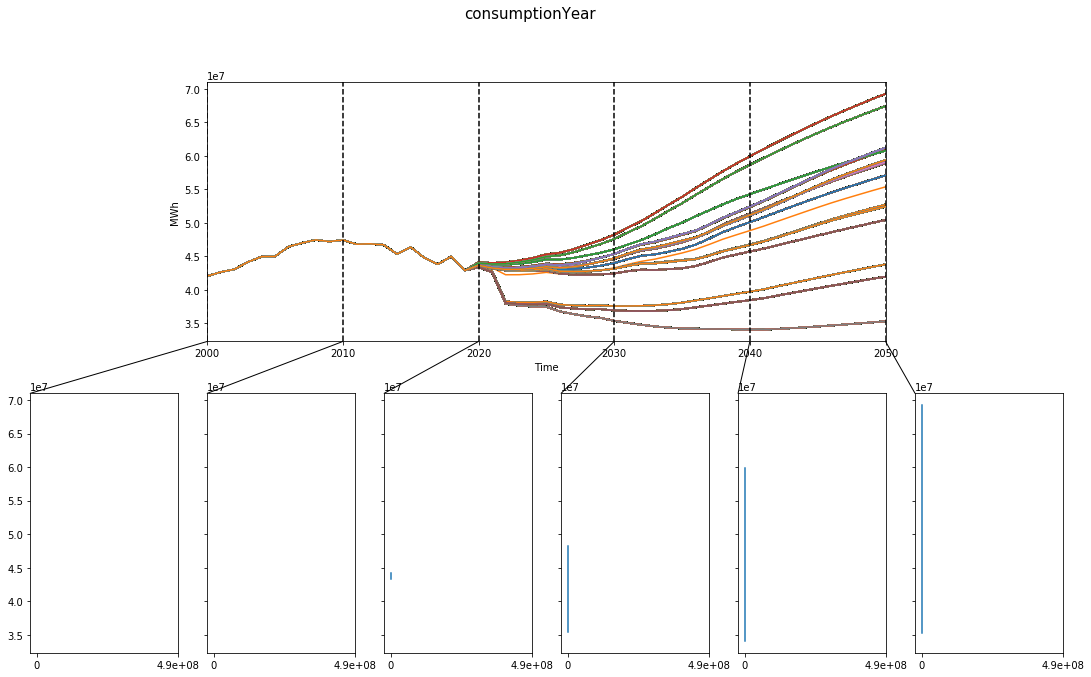

In [303]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "MWh"}, legend=True,
                                 fill=False, plot_type=PlotType.ENV_LIN)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_line_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

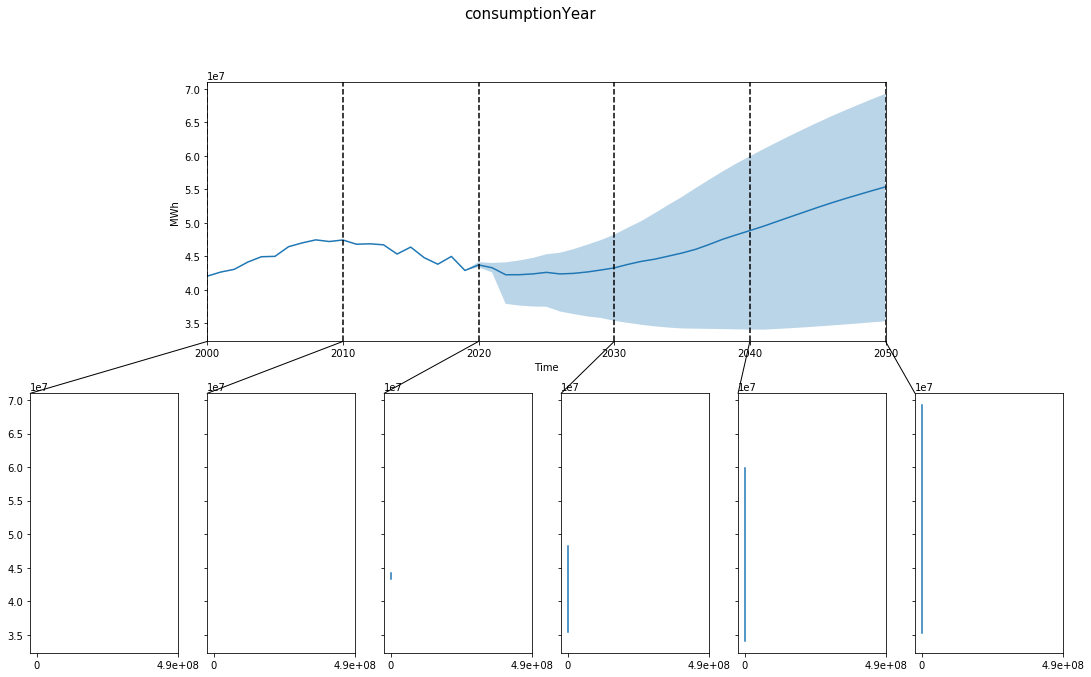

In [304]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "MWh"}, legend=True,
                                 fill=True, plot_type=PlotType.ENVELOPE)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

In [ ]:
from EMAworkbench.ema_workbench.analysis import prim
from EMAworkbench.ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);
 
x = exp
#y = out_avg_ooi > 40000000
y = target_at_year( outcomes_filtered, ooi, 2035, 40000000, False) #False is below target

prim_alg = prim.Prim(x, y, threshold=0.3)
box1 = prim_alg.find_box()

In [ ]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "MWh"}, legend=True,
                                 fill=True, plot_type=PlotType.ENVELOPE)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

In [45]:
from EMAworkbench.ema_workbench.analysis import prim
from EMAworkbench.ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);
 
x = exp
#y = out_avg_ooi > 40000000
y = target_at_year( outcomes_filtered, ooi, 2035, 40000000, False) #False is below target

prim_alg = prim.Prim(x, y, threshold=0.3)
box1 = prim_alg.find_box()

AssertionError: 

In [ ]:
box1.inspect_tradeoff()

In [ ]:
%matplotlib inline
box_1 = box1.inspect(2)
box_1 = box1.inspect(2, style='graph')

In [ ]:
box1.select(2)
fig = box1.show_pairs_scatter(2)
plt.show()

## Consumption

In [305]:
# Subset Sool levers
selected_uncertainties = list(['annualCpi','priceChangePercentageWind','priceChangePercentageWater',
                        'semiScheduleMinCapMarketGen'])    

selected_uncertainties = uncertainties

ooi = 'consumptionYear'
data = outcomes_filtered[ooi]

num_exp = len(data)
out_avg_ooi = np.zeros(num_exp)

for i in range(num_exp):
    out_avg_ooi[i] = data[i].mean()

exp = pd.DataFrame(experiments)

exp = exp.loc[ :, selected_uncertainties] 

### Open Exploration: Visual Analysis

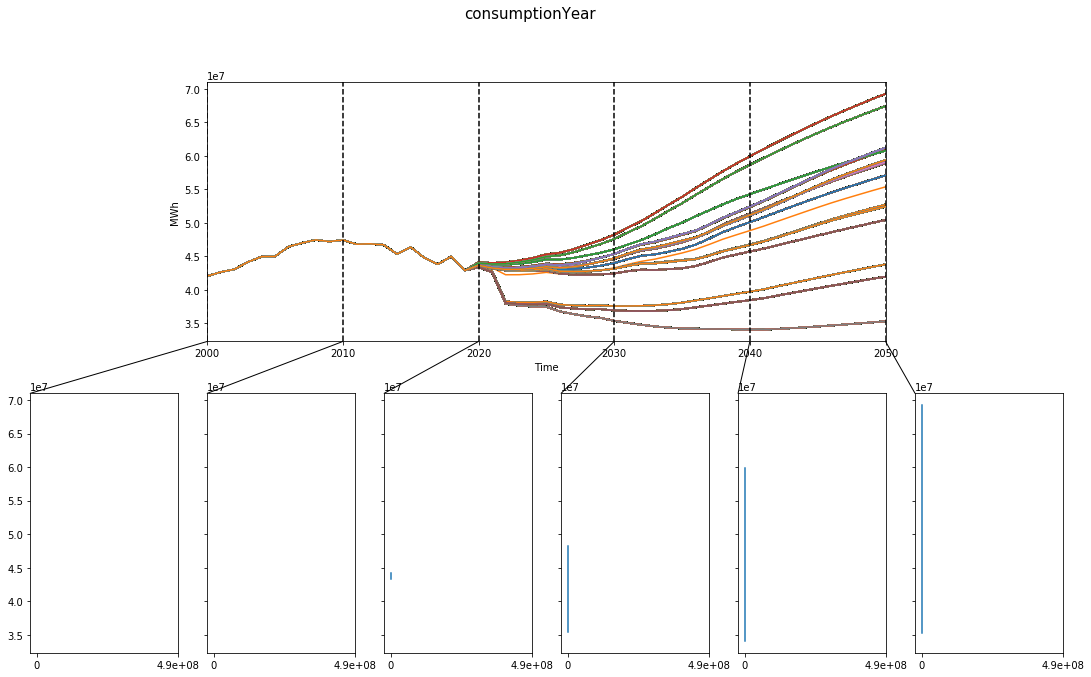

In [306]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "MWh"}, legend=True,
                                 fill=False, plot_type=PlotType.ENV_LIN)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_line_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

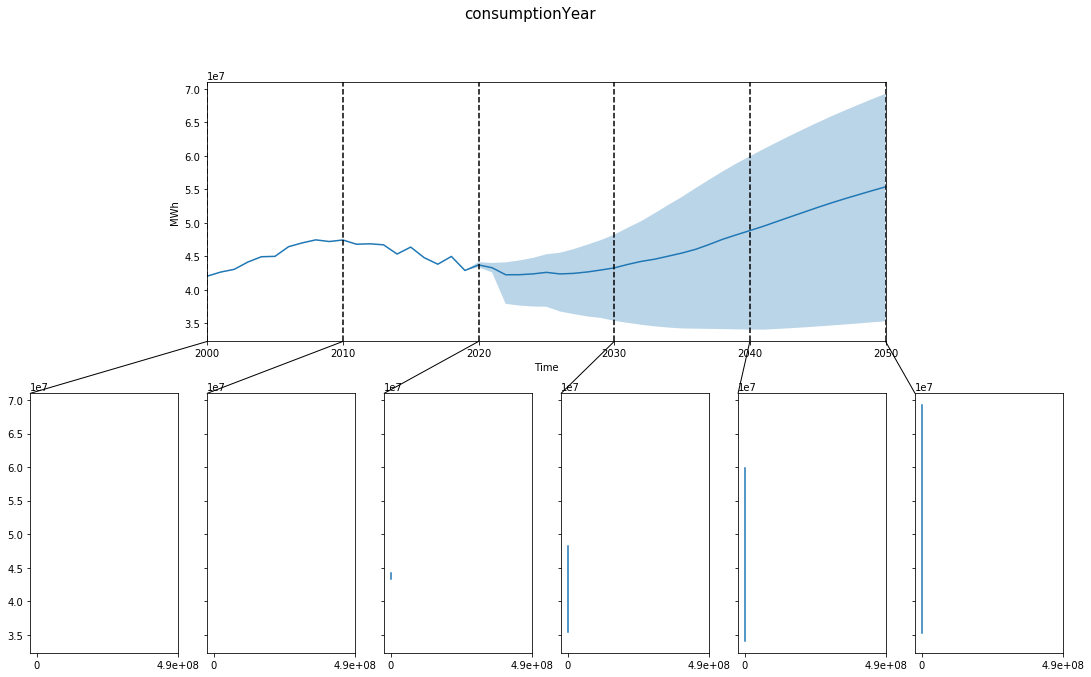

In [307]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density

fig, ax_env = multiple_densities(experiments, outcomes_filtered, outcomes_to_show = ooi,
                                 points_in_time=points_of_interest,  density = Density.KDE,
                                 grouping_specifiers=None , titles={ooi}, ylabels={ooi: "MWh"}, legend=True,
                                 fill=True, plot_type=PlotType.ENVELOPE)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(time[range(0,len(time),10)])

fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_envelope_density_%s'%(ooi)),
                dpi=300, bbox_inches='tight')

In [45]:
from EMAworkbench.ema_workbench.analysis import prim
from EMAworkbench.ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);
 
x = exp
#y = out_avg_ooi > 40000000
y = target_at_year( outcomes_filtered, ooi, 2035, 40000000, False) #False is below target

prim_alg = prim.Prim(x, y, threshold=0.3)
box1 = prim_alg.find_box()

AssertionError: 

In [ ]:
box1.inspect_tradeoff()

In [ ]:
%matplotlib inline
box_1 = box1.inspect(2)
box_1 = box1.inspect(2, style='graph')

In [ ]:
box1.select(2)
fig = box1.show_pairs_scatter(2)
plt.show()